# Unleash Mind-Blowing Images: How Controllable Diffusion Models Transform Text into Visual Masterpieces

## Abstract

This notebook provides a comprehensive introduction to text-to-image generation using diffusion models, with a focus on controllability aspects. Text-to-image generation has revolutionized creative workflows and content creation by enabling the production of high-quality, diverse images from natural language descriptions. Diffusion models have emerged as the state-of-the-art approach for this task, outperforming previous methods like GANs and VAEs in image quality, diversity, and controllability.

In this notebook, we explore the theoretical foundations of diffusion models, their architecture, training methodologies, and practical implementations. We pay special attention to controllability techniques that allow for precise manipulation of generated outputs, including prompt engineering, guidance methods, and conditioning approaches. By the end of this notebook, readers will understand how diffusion models work, how they can be controlled to generate specific outputs, and how to implement and fine-tune these models for various applications.

## 1. Introduction to Generative Models

### 1.1 Overview of Generative AI Paradigms

Generative AI models aim to learn the underlying distribution of training data to generate new, synthetic samples that resemble the original data. Several paradigms have emerged over the years:

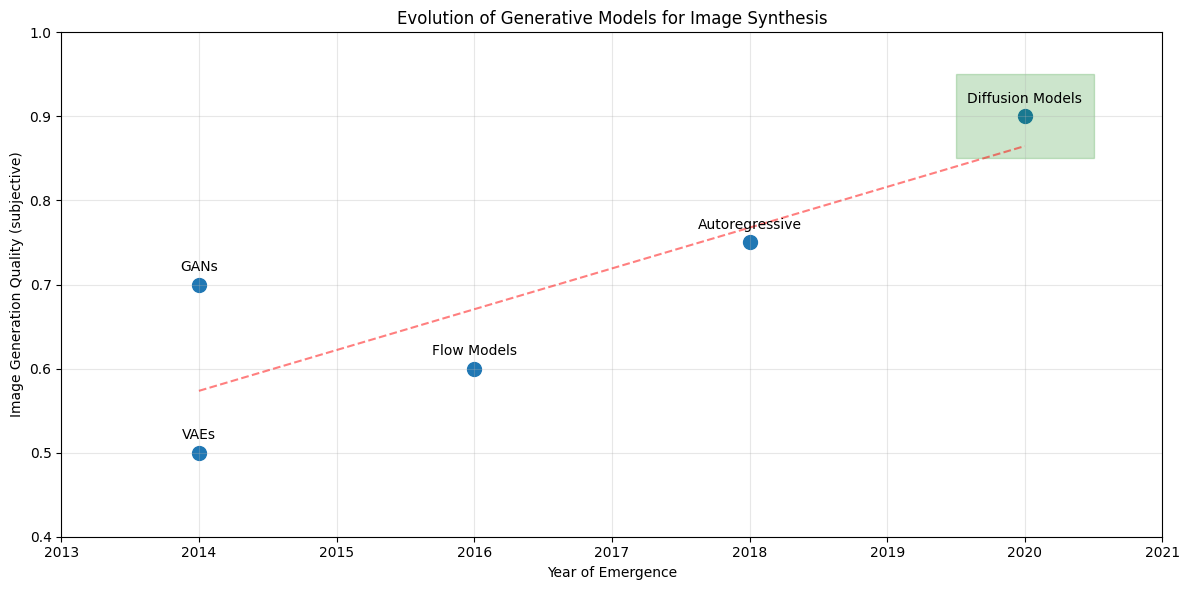

In [1]:
# Visual representation of generative model paradigms
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Define positions
models = ['VAEs', 'GANs', 'Flow Models', 'Autoregressive', 'Diffusion Models']
years = [2014, 2014, 2016, 2018, 2020]
quality = [0.5, 0.7, 0.6, 0.75, 0.9]  # Subjective quality metric

# Plot
ax.scatter(years, quality, s=100)
for i, model in enumerate(models):
    ax.annotate(model, (years[i], quality[i]), xytext=(0, 10), 
                textcoords='offset points', ha='center')

# Add trend line
z = np.polyfit(years, quality, 1)
p = np.poly1d(z)
ax.plot(years, p(years), "r--", alpha=0.5)

# Highlight diffusion models
ax.add_patch(Rectangle((2019.5, 0.85), 1, 0.1, 
                      fill=True, alpha=0.2, color='green'))

ax.set_xlabel('Year of Emergence')
ax.set_ylabel('Image Generation Quality (subjective)')
ax.set_title('Evolution of Generative Models for Image Synthesis')
ax.set_ylim(0.4, 1.0)
ax.set_xlim(2013, 2021)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

The main generative paradigms include:

1. **Variational Autoencoders (VAEs)**: Encode inputs into a latent space and decode them back, using a variational approach to ensure a well-behaved latent space.
2. **Generative Adversarial Networks (GANs)**: Use a generator and discriminator network in a minimax game to produce realistic images.
3. **Flow Models**: Transform a simple distribution into a complex one through a series of invertible transformations.
4. **Autoregressive Models**: Generate outputs sequentially, one element at a time.
5. **Diffusion Models**: Gradually denoise a random signal to produce an image, reversing a forward diffusion process.

### 1.2 Brief History of Text-to-Image Generation

Text-to-image generation has evolved significantly:

In [2]:
# Timeline of text-to-image models
import pandas as pd
from IPython.display import display, HTML

data = {
    'Year': [2016, 2018, 2021, 2022, 2022, 2022, 2023],
    'Model': ['GAN-INT-CLS', 'AttnGAN', 'DALL-E', 'DALL-E 2', 'Stable Diffusion', 'Imagen', 'Midjourney v5'],
    'Architecture': ['GAN', 'GAN', 'Transformer', 'Diffusion', 'Latent Diffusion', 'Diffusion', 'Diffusion'],
    'Key Innovation': [
        'First text-conditional GAN',
        'Multi-scale attention for fine-grained text alignment',
        'Discrete VAE with autoregressive prior',
        'CLIP-guided diffusion model',
        'Diffusion in compressed latent space',
        'Cascaded diffusion with T5 text encoder',
        'Advanced prompt understanding and aesthetic quality'
    ]
}

df = pd.DataFrame(data)
display(HTML(df.to_html(index=False)))

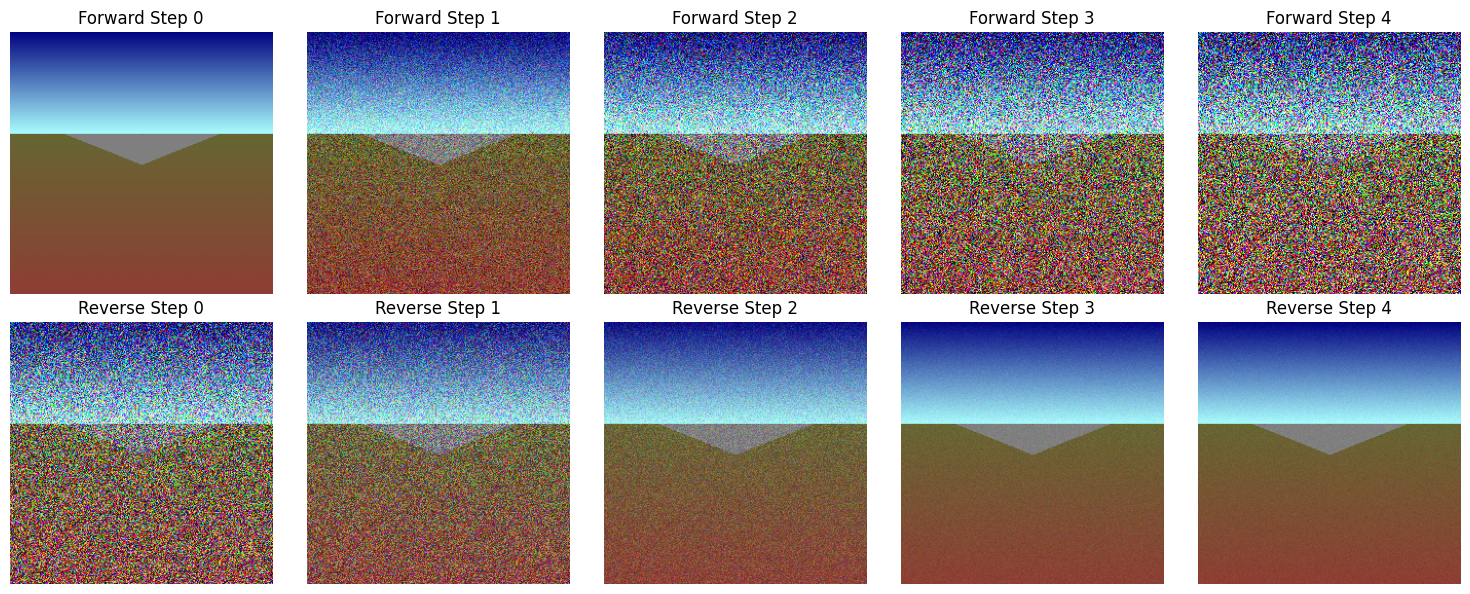

In [5]:
# Visualize the forward and reverse diffusion process
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Function to add Gaussian noise
def add_noise(img, noise_level):
    # Ensure noise_level is positive
    noise_level = abs(noise_level)
    noise = np.random.normal(0, noise_level, img.shape)
    noisy_img = img + noise
    return np.clip(noisy_img, 0, 1)

# Create a simple landscape-like gradient
img = np.zeros((256, 256, 3))
# Create a simple landscape-like gradient
for i in range(256):
    for j in range(256):
        # Sky gradient (blue to light blue)
        if i < 100:
            img[i, j, 0] = i/150  # R
            img[i, j, 1] = i/100  # G
            img[i, j, 2] = 0.5 + i/200  # B
        # Mountain outline (gray)
        elif (i > 100 - abs(j-128)/2) and (i < 130 - abs(j-128)/2.5):
            img[i, j, 0] = 0.5  # R
            img[i, j, 1] = 0.5  # G
            img[i, j, 2] = 0.5  # B
        # Ground/grass (green-brown)
        else:
            img[i, j, 0] = 0.3 + i/1000  # R
            img[i, j, 1] = 0.5 - i/1000  # G
            img[i, j, 2] = 0.2  # B

# Create noise steps
steps = 5
noise_levels = np.linspace(0, 0.6, steps)

plt.figure(figsize=(15, 6))
# Forward process (adding noise)
noisy_images = []
for i in range(steps):
    plt.subplot(2, steps, i+1)
    noisy_img = add_noise(img, noise_levels[i])
    noisy_images.append(noisy_img.copy())
    plt.imshow(noisy_img)
    plt.title(f"Forward Step {i}")
    plt.axis('off')

# Simulated reverse process (removing noise)
# Start with the noisiest image
reverse_img = noisy_images[-1].copy()
for i in range(steps):
    plt.subplot(2, steps, steps+i+1)
    # For reverse process, simulate denoising by blending with original
    alpha = (i+1)/steps  # Gradually increase original image influence
    reverse_img = (1-alpha) * reverse_img + alpha * img
    # Add a small amount of noise to make it look more realistic
    reverse_img = add_noise(reverse_img, 0.02)
    plt.imshow(reverse_img)
    plt.title(f"Reverse Step {i}")
    plt.axis('off')
    
plt.tight_layout()
plt.show()

The field has seen a paradigm shift from GAN-based approaches to diffusion-based models, with significant improvements in image quality, diversity, and text alignment.

## 2. Understanding Diffusion Models

### 2.1 Theoretical Foundations

Diffusion models work on the principle of gradually adding noise to an image (forward process) and then learning to reverse this process (reverse process).

The diffusion process can be mathematically described as:

1. **Forward Process (q)**: Gradually adds Gaussian noise to an image x₀, producing a sequence x₁, x₂, ..., xₜ according to:
   
   q(xₜ|xₜ₋₁) = N(xₜ; √(1-β)xₜ₋₁, βI)

   where β is a noise schedule that controls the amount of noise added at each step.

2. **Reverse Process (p)**: Learns to remove noise, starting from pure noise xₜ and working backward to recover the original image:

   p(xₜ₋₁|xₜ) = N(xₜ₋₁; μ(xₜ, t), Σ(xₜ, t))

   where μ and Σ are learned by a neural network.

### 2.2 Comparison with Other Generative Models

Diffusion models offer several advantages over other approaches:

In [7]:
# Comparison of generative model characteristics
import pandas as pd
from IPython.display import display, HTML

comparison = {
    'Model Type': ['GANs', 'VAEs', 'Flow Models', 'Diffusion Models'],
    'Training Stability': ['Low', 'High', 'High', 'High'],
    'Sample Quality': ['High', 'Medium', 'Medium', 'Very High'],
    'Sampling Speed': ['Fast', 'Fast', 'Medium', 'Slow'],
    'Mode Coverage': ['Low', 'Medium', 'High', 'High'],
    'Controllability': ['Medium', 'Medium', 'Low', 'High'],
    'Conditioning Flexibility': ['Medium', 'Low', 'Medium', 'High']
}

df_comparison = pd.DataFrame(comparison)
display(HTML(df_comparison.to_html(index=False)))

Key advantages of diffusion models include:
- Training stability (no adversarial training)
- High sample quality and diversity
- Strong mode coverage (less mode collapse)
- Flexible conditioning mechanisms
- Theoretically well-founded (based on variational inference)

The main disadvantage is sampling speed, as they require multiple steps (typically 50-1000) to generate each image.

## 3. Text Conditioning in Diffusion Models

### 3.1 Text Encoders

Text conditioning allows diffusion models to generate images based on text prompts. This requires a text encoder to convert text into embeddings.

In [11]:
# Simplified CLIP text encoder example
import torch
import torch.nn as nn

class SimpleTransformerEncoder(nn.Module):
    def __init__(self, vocab_size=10000, embed_dim=512, num_heads=8, num_layers=6):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, embed_dim)
        self.position_embedding = nn.Parameter(torch.zeros(1, 77, embed_dim))
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.ln_final = nn.LayerNorm(embed_dim)
        
    def forward(self, text_tokens):
        x = self.token_embedding(text_tokens)
        x = x + self.position_embedding
        x = self.transformer(x)
        x = self.ln_final(x)
        return x

# Create example model
text_encoder = SimpleTransformerEncoder()
print(f"Total parameters: {sum(p.numel() for p in text_encoder.parameters() if p.requires_grad):,}")

# Example input
dummy_tokens = torch.randint(0, 10000, (1, 77))
output = text_encoder(dummy_tokens)
print(f"Output shape: {output.shape}")

Total parameters: 24,074,752
Output shape: torch.Size([1, 77, 512])


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Popular text encoders used in diffusion models include:
- **CLIP**: Contrastive Language-Image Pre-training model by OpenAI (used in DALL-E 2, Stable Diffusion)
- **T5**: Text-to-Text Transfer Transformer by Google (used in Imagen)
- **BERT**: Bidirectional Encoder Representations from Transformers

### 3.2 Cross-Attention Mechanisms

Cross-attention is the key mechanism that allows diffusion models to incorporate text information into the image generation process.

In [12]:
# Simplified cross-attention implementation
import torch
import torch.nn as nn
import torch.nn.functional as F

class CrossAttention(nn.Module):
    def __init__(self, query_dim, context_dim, heads=8, dim_head=64):
        super().__init__()
        inner_dim = dim_head * heads
        self.scale = dim_head ** -0.5
        self.heads = heads

        self.to_q = nn.Linear(query_dim, inner_dim, bias=False)
        self.to_k = nn.Linear(context_dim, inner_dim, bias=False)
        self.to_v = nn.Linear(context_dim, inner_dim, bias=False)
        self.to_out = nn.Linear(inner_dim, query_dim)

    def forward(self, x, context):
        h = self.heads

        q = self.to_q(x)
        k = self.to_k(context)
        v = self.to_v(context)

        q, k, v = map(lambda t: t.reshape(*t.shape[:-1], h, -1).transpose(-3, -2), (q, k, v))
        
        # Attention
        sim = torch.einsum('bhid,bhjd->bhij', q, k) * self.scale
        attn = F.softmax(sim, dim=-1)
        out = torch.einsum('bhij,bhjd->bhid', attn, v)
        
        out = out.transpose(-3, -2).reshape(*x.shape[:-1], -1)
        return self.to_out(out)

# Example usage
query = torch.randn(1, 64, 512)  # Feature map from diffusion model
context = torch.randn(1, 77, 512)  # Text embeddings

cross_attn = CrossAttention(query_dim=512, context_dim=512)
output = cross_attn(query, context)

print(f"Input shape: {query.shape}")
print(f"Context shape: {context.shape}")
print(f"Output shape: {output.shape}")

Input shape: torch.Size([1, 64, 512])
Context shape: torch.Size([1, 77, 512])
Output shape: torch.Size([1, 64, 512])


In a text-conditioned diffusion model, cross-attention works by:
1. Using image features as queries
2. Using text embeddings as keys and values
3. Allowing the model to attend to relevant parts of the text description when generating each part of the image

### 3.3 Text Embedding and Conditioning Techniques

Different text conditioning approaches provide varying degrees of control:

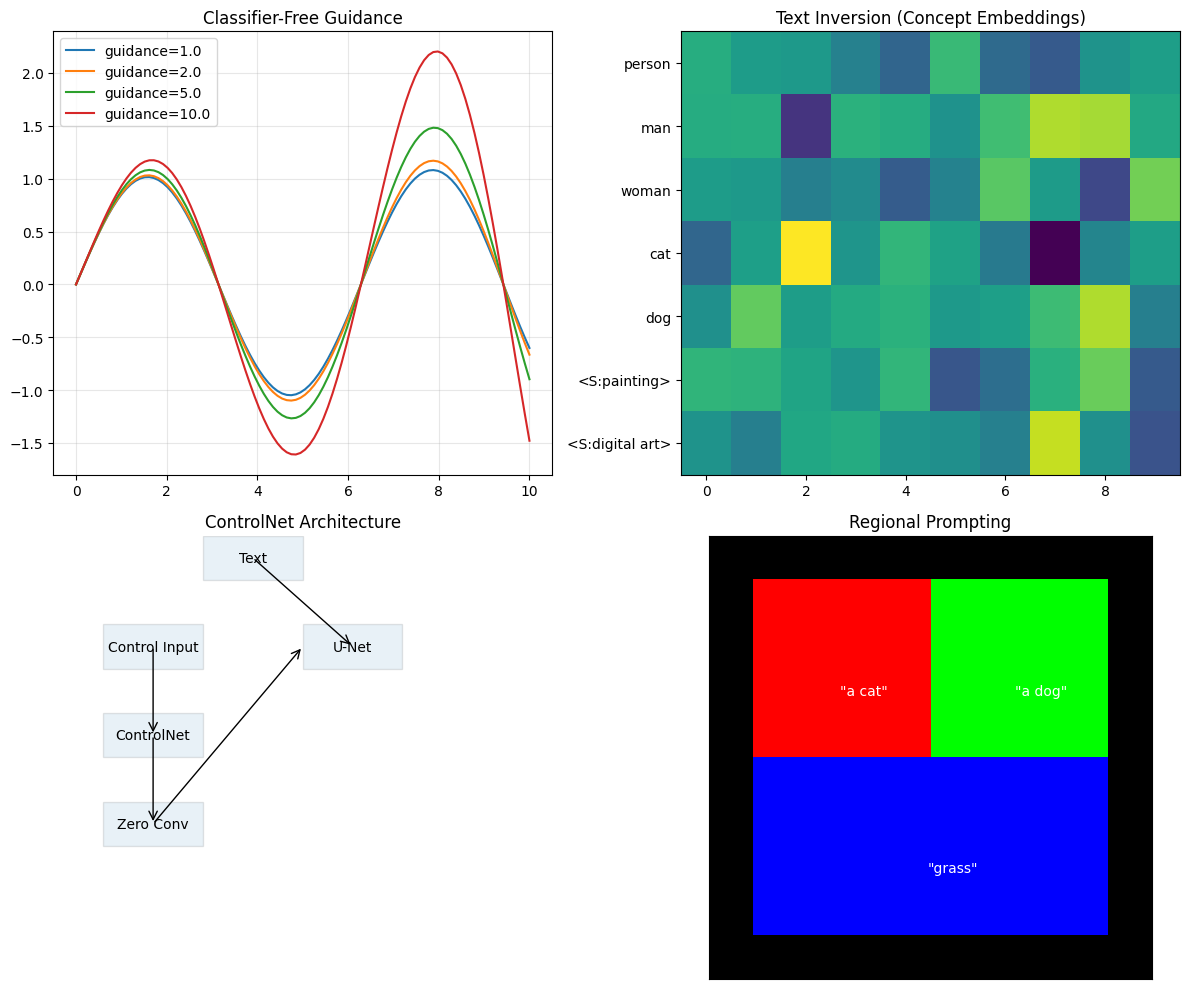

In [13]:
# Visualization of different conditioning approaches
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Classifier-free guidance
x = np.linspace(0, 10, 100)
for i, w in enumerate([1.0, 2.0, 5.0, 10.0]):
    y = np.sin(x) * np.exp(w * 0.1 * x / 10)
    axes[0, 0].plot(x, y, label=f"guidance={w}")
axes[0, 0].set_title("Classifier-Free Guidance")
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Text inversion
vocab = ["person", "man", "woman", "cat", "dog", "<S:painting>", "<S:digital art>"]
embeddings = np.random.randn(len(vocab), 10)
axes[0, 1].imshow(embeddings, aspect='auto', cmap='viridis')
axes[0, 1].set_yticks(np.arange(len(vocab)))
axes[0, 1].set_yticklabels(vocab)
axes[0, 1].set_title("Text Inversion (Concept Embeddings)")

# ControlNet
# Simplified visualization of ControlNet architecture
from matplotlib.patches import Rectangle, FancyArrowPatch

def add_box(ax, x, y, width, height, name):
    rect = Rectangle((x, y), width, height, fill=True, alpha=0.1, edgecolor='black')
    ax.add_patch(rect)
    ax.text(x + width/2, y + height/2, name, ha='center', va='center')
    return x + width/2, y + height/2

def add_arrow(ax, start, end):
    arrow = FancyArrowPatch(start, end, arrowstyle='->', mutation_scale=15)
    ax.add_patch(arrow)

# ControlNet diagram
ax = axes[1, 0]
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.axis('off')

# Main blocks
c1 = add_box(ax, 1, 7, 2, 1, "Control Input")
u1 = add_box(ax, 5, 7, 2, 1, "U-Net")
t1 = add_box(ax, 3, 9, 2, 1, "Text")

# Control blocks
c2 = add_box(ax, 1, 5, 2, 1, "ControlNet")
c3 = add_box(ax, 1, 3, 2, 1, "Zero Conv")

# Connect
add_arrow(ax, t1, u1)
add_arrow(ax, c1, c2)
add_arrow(ax, c2, c3)
add_arrow(ax, c3, (u1[0]-1, u1[1]))

ax.set_title("ControlNet Architecture")

# Regional Prompting
ax = axes[1, 1]
img = np.zeros((10, 10, 3))
# Create regions
img[1:5, 1:5] = [1, 0, 0]  # Red region
img[1:5, 5:9] = [0, 1, 0]  # Green region
img[5:9, 1:9] = [0, 0, 1]  # Blue region

ax.imshow(img)
ax.text(3, 3, "\"a cat\"", color='white', ha='center', va='center')
ax.text(7, 3, "\"a dog\"", color='white', ha='center', va='center')
ax.text(5, 7, "\"grass\"", color='white', ha='center', va='center')
ax.set_title("Regional Prompting")
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.show()

Key text conditioning techniques include:

1. **Classifier-Free Guidance**: Controls the trade-off between fidelity to the text prompt and image quality.
   
   Score = (1+w) * score_conditional - w * score_unconditional
   
   Where w is the guidance scale (typically 7-15).

2. **Text Inversion**: Learns special tokens that represent visual concepts not in the text encoder's vocabulary.

3. **ControlNet**: Adds spatial conditioning by using additional control signals (edges, depth maps, etc.).

4. **Regional Prompting**: Allows different text prompts for different regions of the image.

## 4. Architecture of Text-to-Image Diffusion Models

### 4.1 U-Net Architecture

The core architecture of most diffusion models is a U-Net with added conditioning mechanisms:

In [17]:
# Transformer blocks for diffusion models - Fixed version
import torch
import torch.nn as nn
import torch.nn.functional as F

class SelfAttention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64):
        super().__init__()
        inner_dim = dim_head * heads
        self.heads = heads
        self.scale = dim_head ** -0.5

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)
        self.to_out = nn.Linear(inner_dim, dim)

    def forward(self, x):
        b, n, d = x.shape
        h = self.heads
        
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: t.reshape(b, n, h, -1).transpose(1, 2), qkv)

        dots = torch.einsum('bhid,bhjd->bhij', q, k) * self.scale
        attn = F.softmax(dots, dim=-1)
        
        out = torch.einsum('bhij,bhjd->bhid', attn, v)
        out = out.transpose(1, 2).reshape(b, n, -1)
        
        return self.to_out(out)

class TransformerBlock(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64, mlp_dim=2048):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = SelfAttention(dim, heads=heads, dim_head=dim_head)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, dim)
        )
        
    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

# Example: Transformer block in diffusion model
# FIXING DIMENSIONS TO ENSURE COMPATIBILITY
spatial_size = 16  # H=W=16
channels = 512  # Dimension of each feature
batch_size = 1

# Create a sample feature map
x = torch.randn(batch_size, channels, spatial_size, spatial_size)

# Reshape spatial features to sequence format for transformer
# [B, C, H, W] -> [B, H*W, C]
x_seq = x.flatten(2).permute(0, 2, 1)  # This fixes the dimension issue
print(f"Sequence shape after reshape: {x_seq.shape}")

# Create transformer with matching dimensions
transformer = TransformerBlock(dim=channels)

# Process through transformer
out_seq = transformer(x_seq)
print(f"Output sequence shape: {out_seq.shape}")

# Reshape back to spatial layout
# [B, H*W, C] -> [B, C, H, W]
out = out_seq.permute(0, 2, 1).reshape(batch_size, channels, spatial_size, spatial_size)

print(f"Input shape: {x.shape}")
print(f"Output shape: {out.shape}")

Sequence shape after reshape: torch.Size([1, 256, 512])
Output sequence shape: torch.Size([1, 256, 512])
Input shape: torch.Size([1, 512, 16, 16])
Output shape: torch.Size([1, 512, 16, 16])


Transformer components enable:
1. **Global context modeling**: Capturing relationships between distant image regions
2. **Improved composition**: Better understanding of complex scene layouts
3. **Enhanced text alignment**: More precise adherence to text descriptions

### 4.3 Key Innovations in Leading Models

Modern text-to-image models have introduced several key architectural innovations:

In [18]:
# Comparison of key model architectures
import pandas as pd
from IPython.display import display, HTML

models = {
    'Model': ['DALL-E 2', 'Stable Diffusion', 'Imagen', 'Midjourney v5'],
    'Base Architecture': ['Diffusion', 'Latent Diffusion', 'Cascaded Diffusion', 'Diffusion (proprietary)'],
    'Text Encoder': ['CLIP', 'CLIP', 'T5-XXL', 'Proprietary'],
    'Key Innovation': [
        'CLIP image embedding alignment',
        'Diffusion in compressed latent space',
        'Super-resolution cascade with classifier-free guidance',
        'Advanced aesthetic refinement'
    ],
    'Conditioning Method': [
        'CLIP embedding + guidance',
        'Cross-attention + guidance',
        'Classifier-free guidance',
        'Proprietary guidance'
    ],
    'Controlability Features': [
        'Text + image variations',
        'ControlNet, inpainting, img2img',
        'Text + layout control',
        'Style, weight, aspect ratio control'
    ]
}

df_models = pd.DataFrame(models)
display(HTML(df_models.to_html(index=False)))

**Stable Diffusion's Latent Diffusion approach**:

Stable Diffusion's key innovation is performing diffusion in a compressed latent space rather than pixel space:

1. An autoencoder compresses images to a lower-dimensional latent space (4x spatial downsampling, 1/8 of original pixels)
2. The diffusion model operates in this latent space (much faster and memory-efficient)
3. The latent representations are finally decoded back to pixel space

This approach dramatically reduces computational requirements while maintaining high image quality.

## 5. Training Methodology

### 5.1 Dataset Requirements

Text-to-image models require large, diverse datasets with high-quality image-text pairs:

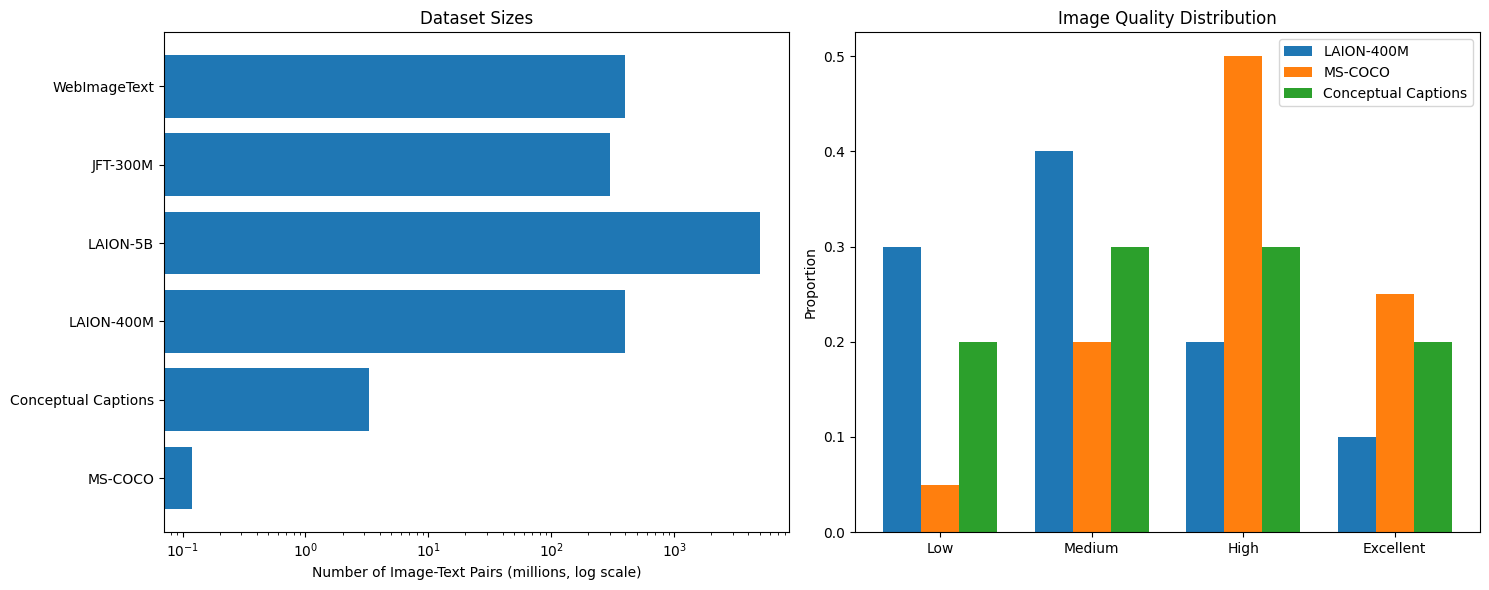

In [19]:
# Example dataset statistics visualization
import matplotlib.pyplot as plt
import numpy as np

# Dataset sizes (millions of image-text pairs)
datasets = ['MS-COCO', 'Conceptual Captions', 'LAION-400M', 'LAION-5B', 'JFT-300M', 'WebImageText']
sizes = [0.12, 3.3, 400, 5000, 300, 400]  # In millions

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Dataset sizes
y_pos = np.arange(len(datasets))
ax1.barh(y_pos, sizes, align='center')
ax1.set_yticks(y_pos)
ax1.set_yticklabels(datasets)
ax1.set_xscale('log')
ax1.set_xlabel('Number of Image-Text Pairs (millions, log scale)')
ax1.set_title('Dataset Sizes')

# Image quality distribution (hypothetical)
quality_bins = ['Low', 'Medium', 'High', 'Excellent']
laion_quality = [0.3, 0.4, 0.2, 0.1]
coco_quality = [0.05, 0.2, 0.5, 0.25]
cc_quality = [0.2, 0.3, 0.3, 0.2]

x = np.arange(len(quality_bins))
width = 0.25

ax2.bar(x - width, laion_quality, width, label='LAION-400M')
ax2.bar(x, coco_quality, width, label='MS-COCO')
ax2.bar(x + width, cc_quality, width, label='Conceptual Captions')

ax2.set_xticks(x)
ax2.set_xticklabels(quality_bins)
ax2.set_ylabel('Proportion')
ax2.set_title('Image Quality Distribution')
ax2.legend()

plt.tight_layout()
plt.show()

Key dataset considerations include:
1. **Scale**: Hundreds of millions to billions of image-text pairs
2. **Diversity**: Wide range of concepts, styles, and compositions
3. **Text quality**: Descriptive and accurate captions
4. **Image quality**: High-resolution, well-composed images
5. **Content filtering**: Removal of harmful or problematic content

Popular datasets include:
- **LAION-5B**: 5 billion image-text pairs from the web
- **Conceptual Captions**: 3.3 million image-text pairs with cleaned captions
- **MS-COCO**: 120,000 images with multiple captions per image

### 5.2 Loss Functions

The core training objective for diffusion models is noise prediction:

In [20]:
# Simplified diffusion training loss
import torch
import torch.nn.functional as F

def diffusion_training_loss(model, x_0, text_embeddings, timesteps):
    """
    Simplified diffusion training loss calculation
    
    Args:
        model: The diffusion model
        x_0: Original images [B, C, H, W]
        text_embeddings: Text conditioning [B, seq_len, embed_dim]
        timesteps: Random timesteps to sample [B]
    """
    batch_size = x_0.shape[0]
    
    # Sample noise
    noise = torch.randn_like(x_0)
    
    # Forward diffusion process (noising)
    # For simplicity, using the closed-form solution for any arbitrary timestep
    alphas = 0.9999 ** timesteps.view(-1, 1, 1, 1)  # Simplified noise schedule
    x_t = torch.sqrt(alphas) * x_0 + torch.sqrt(1 - alphas) * noise
    
    # Model predicts the noise
    noise_pred = model(x_t, timesteps, text_embeddings)
    
    # Loss is MSE between actual and predicted noise
    loss = F.mse_loss(noise_pred, noise)
    
    return loss

# Example usage
batch_size = 8
channels = 3
height = 64
width = 64
embed_dim = 768
seq_len = 77

# Dummy data
x_0 = torch.randn(batch_size, channels, height, width)
text_embeddings = torch.randn(batch_size, seq_len, embed_dim)
timesteps = torch.randint(0, 1000, (batch_size,))

# Simplified model (just for demonstration)
dummy_model = lambda x, t, c: torch.randn_like(x)

# Calculate loss
loss = diffusion_training_loss(dummy_model, x_0, text_embeddings, timesteps)
print(f"Training loss: {loss.item()}")

Training loss: 2.009263038635254


The training process:

1. **Sample random timesteps** t for each image in the batch
2. **Add noise** to create noisy images x_t
3. **Predict the noise** added to each image using the model
4. **Calculate MSE loss** between predicted and actual noise
5. **Update weights** using gradient descent

For text conditioning, the model learns to predict noise conditioned on text embeddings.

### 5.3 Sampling Strategies

Various sampling strategies can be used to generate images from trained diffusion models:

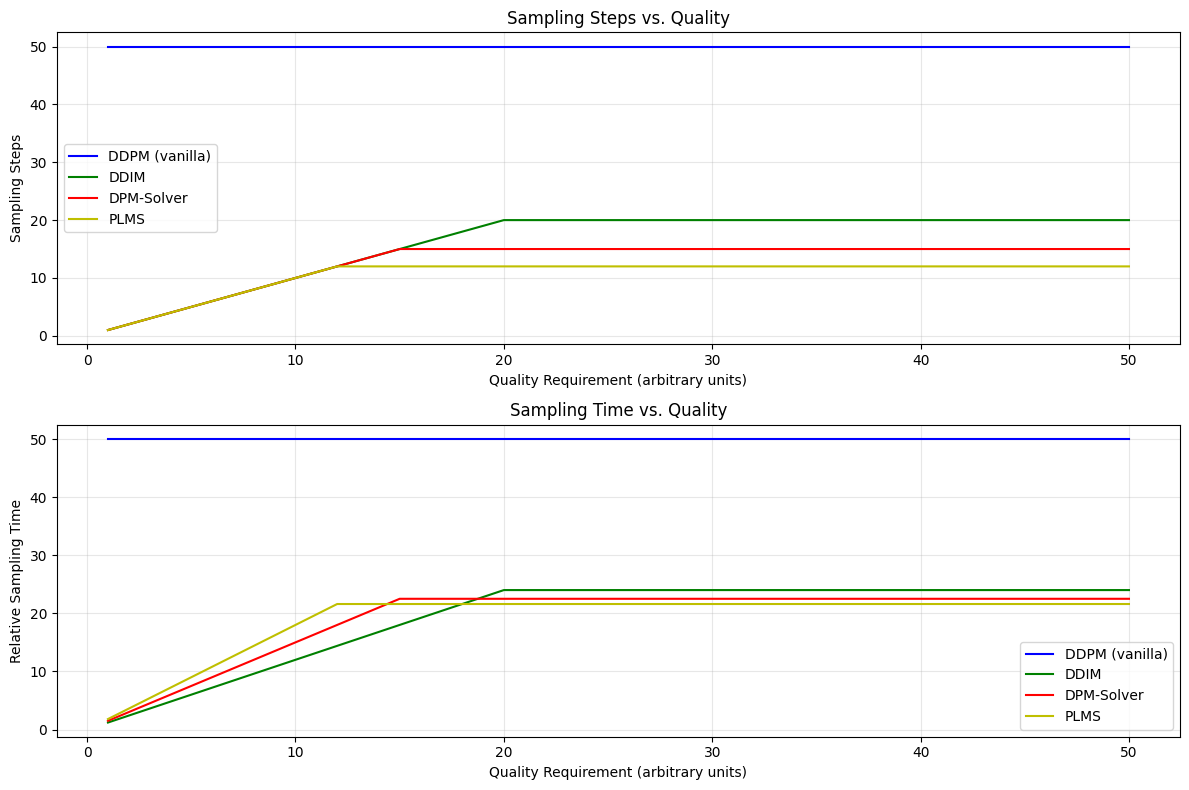

In [21]:
# Visualization of different sampling strategies
import matplotlib.pyplot as plt
import numpy as np

# Sampling steps for different strategies
steps = np.arange(1, 51)
ddpm_curve = 50 * np.ones_like(steps)  # Always 50 steps
ddim_curve = np.minimum(steps, 20)  # Reduced steps (max 20)
dpm_curve = np.minimum(steps, 15)  # Further reduced (max 15)
plms_curve = np.minimum(steps, 12)  # Even fewer steps (max 12)

# Sampling time (relative)
ddpm_time = ddpm_curve * 1.0
ddim_time = ddim_curve * 1.2  # Slightly more computation per step
dpm_time = dpm_curve * 1.5    # More computation per step
plms_time = plms_curve * 1.8  # Most computation per step

plt.figure(figsize=(12, 8))

# Plot sampling steps
plt.subplot(2, 1, 1)
plt.plot(steps, ddpm_curve, 'b-', label='DDPM (vanilla)')
plt.plot(steps, ddim_curve, 'g-', label='DDIM')
plt.plot(steps, dpm_curve, 'r-', label='DPM-Solver')
plt.plot(steps, plms_curve, 'y-', label='PLMS')
plt.xlabel('Quality Requirement (arbitrary units)')
plt.ylabel('Sampling Steps')
plt.title('Sampling Steps vs. Quality')
plt.legend()
plt.grid(alpha=0.3)

# Plot sampling time
plt.subplot(2, 1, 2)
plt.plot(steps, ddpm_time, 'b-', label='DDPM (vanilla)')
plt.plot(steps, ddim_time, 'g-', label='DDIM')
plt.plot(steps, dpm_time, 'r-', label='DPM-Solver')
plt.plot(steps, plms_time, 'y-', label='PLMS')
plt.xlabel('Quality Requirement (arbitrary units)')
plt.ylabel('Relative Sampling Time')
plt.title('Sampling Time vs. Quality')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

Common sampling strategies include:

1. **DDPM (Denoising Diffusion Probabilistic Models)**:
   - Original sampling procedure
   - Uses 1000+ steps for high-quality results
   - Slow but very stable

2. **DDIM (Denoising Diffusion Implicit Models)**:
   - Deterministic sampling process
   - Can reduce steps to 50-100 with minimal quality loss
   - Enables "inversion" for image editing

3. **DPM-Solver**:
   - Higher-order solver for the diffusion ODE
   - Can generate high-quality samples in 10-20 steps
   - Based on numerical ODE solvers

4. **PLMS (Pseudo Linear Multistep)**:
   - Uses previous step predictions to improve estimates
   - Good quality with 20-30 steps

The choice of sampling strategy affects both generation speed and image quality.

### 5.4 Computational Considerations

Training and running text-to-image diffusion models requires significant computational resources:

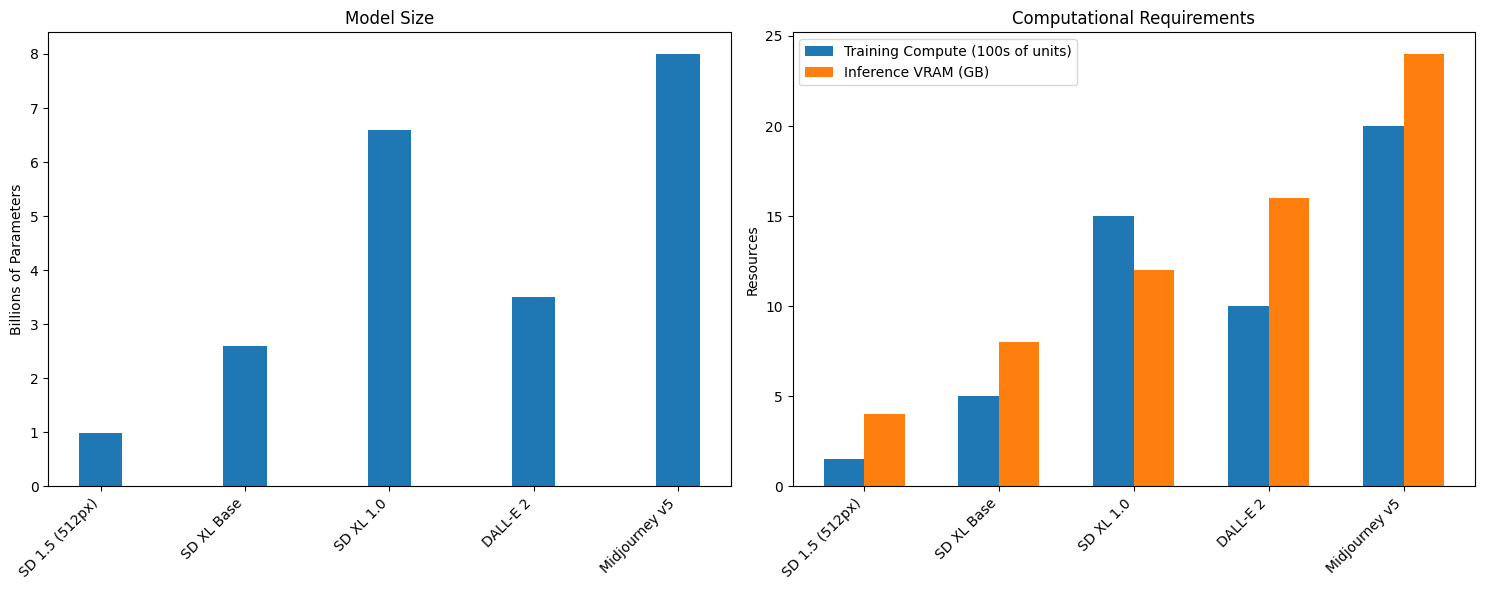

In [22]:
# Computational requirements visualization
import matplotlib.pyplot as plt
import numpy as np

models = ['SD 1.5 (512px)', 'SD XL Base', 'SD XL 1.0', 'DALL-E 2', 'Midjourney v5']
parameters = [0.98, 2.6, 6.6, 3.5, 8.0]  # Billions
training_compute = [150, 500, 1500, 1000, 2000]  # Arbitrary units
vram_inference = [4, 8, 12, 16, 24]  # GB VRAM for inference

x = np.arange(len(models))
width = 0.3

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Model size
ax1.bar(x, parameters, width, label='Parameters (B)')
ax1.set_ylabel('Billions of Parameters')
ax1.set_title('Model Size')
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=45, ha='right')

# Compute and VRAM
ax2.bar(x - width/2, np.array(training_compute)/100, width, label='Training Compute (100s of units)')
ax2.bar(x + width/2, vram_inference, width, label='Inference VRAM (GB)')
ax2.set_ylabel('Resources')
ax2.set_title('Computational Requirements')
ax2.set_xticks(x)
ax2.set_xticklabels(models, rotation=45, ha='right')
ax2.legend()

plt.tight_layout()
plt.show()

Computational requirements include:

1. **Training**:
   - Multiple high-end GPUs (8-16 A100s or equivalent)
   - Training time: weeks to months
   - Hundreds of terabytes of image data
   - Specialized distributed training infrastructure

2. **Inference**:
   - Production models: GPU with 8-24GB VRAM
   - Full-precision inference: higher VRAM, better quality
   - Optimized inference: reduced precision (FP16/INT8)
   - Typical generation time: 2-30 seconds per image

3. **Optimization techniques**:
   - Model pruning
   - Knowledge distillation
   - Low-rank adaptations
   - Efficient attention mechanisms

## 6. Evaluation Metrics

### 6.1 Automated Metrics

Various metrics can be used to evaluate text-to-image diffusion models:

In [23]:
# Comparison of evaluation metrics
import pandas as pd
from IPython.display import display, HTML

metrics = {
    'Metric': ['FID (Fréchet Inception Distance)', 'CLIP Score', 'IS (Inception Score)', 'LPIPS', 'MS-SSIM'],
    'Evaluates': ['Image quality/realism', 'Text-image alignment', 'Image quality/diversity', 'Perceptual diversity', 'Visual similarity'],
    'Range': ['Lower is better (0+)', 'Higher is better (0-100%)', 'Higher is better (1+)', 'Higher is more diverse (0-1)', 'Lower is more similar (0-1)'],
    'Pros': [
        'Well-established, correlates with human judgment',
        'Directly measures text-image alignment',
        'Measures both quality and diversity',
        'Captures perceptual differences well',
        'Fast, differentiable'
    ],
    'Cons': [
        'Requires large reference dataset, based on Inception',
        'Biased toward CLIP training data',
        'Less sensitive to text alignment',
        'Less established for generative models',
        'Only measures similarity, not quality'
    ]
}

df_metrics = pd.DataFrame(metrics)
display(HTML(df_metrics.to_html(index=False)))

In [24]:
# Simplified CLIP score calculation
import torch
import torch.nn.functional as F
import numpy as np

def clip_score(text_features, image_features):
    """
    Calculate CLIP score between text and image embeddings
    
    Args:
        text_features: Text embeddings [B, D]
        image_features: Image embeddings [B, D]
    
    Returns:
        clip_score: CLIP scores [B]
    """
    # Normalize features
    text_features = F.normalize(text_features, dim=-1)
    image_features = F.normalize(image_features, dim=-1)
    
    # Calculate cosine similarity
    similarity = torch.sum(text_features * image_features, dim=-1)
    
    # Convert to percentage
    clip_score = similarity * 100
    
    return clip_score

# Example
batch_size = 4
embed_dim = 512

# Simulated CLIP embeddings (normalized for simplicity)
text_features = F.normalize(torch.randn(batch_size, embed_dim), dim=-1)
image_features = F.normalize(torch.randn(batch_size, embed_dim), dim=-1)

# Calculate CLIP scores
scores = clip_score(text_features, image_features)

print("CLIP Scores:")
for i, score in enumerate(scores):
    print(f"Sample {i+1}: {score.item():.2f}%")

CLIP Scores:
Sample 1: 0.78%
Sample 2: 0.23%
Sample 3: 2.20%
Sample 4: -3.34%


Key metrics include:

1. **FID (Fréchet Inception Distance)**:
   - Measures distance between feature distributions of real and generated images
   - Lower values indicate more realistic images

2. **CLIP Score**:
   - Measures alignment between text prompts and generated images
   - Higher values indicate better text-image correspondence

3. **IS (Inception Score)**:
   - Measures both quality and diversity
   - Higher values indicate more realistic and diverse images

4. **Aesthetic Score**:
   - Measures aesthetic quality based on human preferences
   - Used in models like Midjourney for aesthetic optimization

### 6.2 Human Evaluation

Human evaluation remains essential for assessing text-to-image models:

In [25]:
# Human evaluation interface example
import ipywidgets as widgets
from IPython.display import display, HTML

# Example images (would be actual images in practice)
images = [f"<div style='border:1px solid gray; padding:5px; text-align:center;'>Example Image {i+1}</div>" for i in range(4)]

# Example prompt
prompt = "A serene landscape with mountains at sunset"

# Evaluation form
html_output = f"""
<div style='background:#f8f8f8; padding:10px; border-radius:5px;'>
    <h3>Human Evaluation Form</h3>
    <p><b>Prompt:</b> {prompt}</p>
    
    <div style='display:grid; grid-template-columns:1fr 1fr; gap:10px;'>
        {''.join(images)}
    </div>
    
    <h4>Please rate each image on the following criteria:</h4>
</div>
"""

display(HTML(html_output))

# Rating widgets
prompts = ["Text Alignment", "Image Quality", "Creativity", "Overall Satisfaction"]
models = ["Model A", "Model B"]

for prompt in prompts:
    print(f"\n{prompt}:")
    for model in models:
        slider = widgets.IntSlider(
            min=1, max=5, step=1, value=3,
            description=f"{model}:",
            style={'description_width': '100px'}
        )
        display(slider)


Text Alignment:


IntSlider(value=3, description='Model A:', max=5, min=1, style=SliderStyle(description_width='100px'))

IntSlider(value=3, description='Model B:', max=5, min=1, style=SliderStyle(description_width='100px'))


Image Quality:


IntSlider(value=3, description='Model A:', max=5, min=1, style=SliderStyle(description_width='100px'))

IntSlider(value=3, description='Model B:', max=5, min=1, style=SliderStyle(description_width='100px'))


Creativity:


IntSlider(value=3, description='Model A:', max=5, min=1, style=SliderStyle(description_width='100px'))

IntSlider(value=3, description='Model B:', max=5, min=1, style=SliderStyle(description_width='100px'))


Overall Satisfaction:


IntSlider(value=3, description='Model A:', max=5, min=1, style=SliderStyle(description_width='100px'))

IntSlider(value=3, description='Model B:', max=5, min=1, style=SliderStyle(description_width='100px'))

Human evaluation approaches include:

1. **Side-by-side comparisons**:
   - Comparing outputs from different models
   - Useful for relative assessments

2. **Absolute ratings**:
   - Rating images on specific criteria
   - Useful for tracking model improvements

3. **Text alignment assessment**:
   - Evaluating how well images match text prompts
   - Identifying strengths and weaknesses in comprehension

4. **Preference data collection**:
   - Used to train reward models
   - Can improve model outputs through reinforcement learning

### 6.3 Limitations of Metrics

It's important to understand the limitations of evaluation metrics:

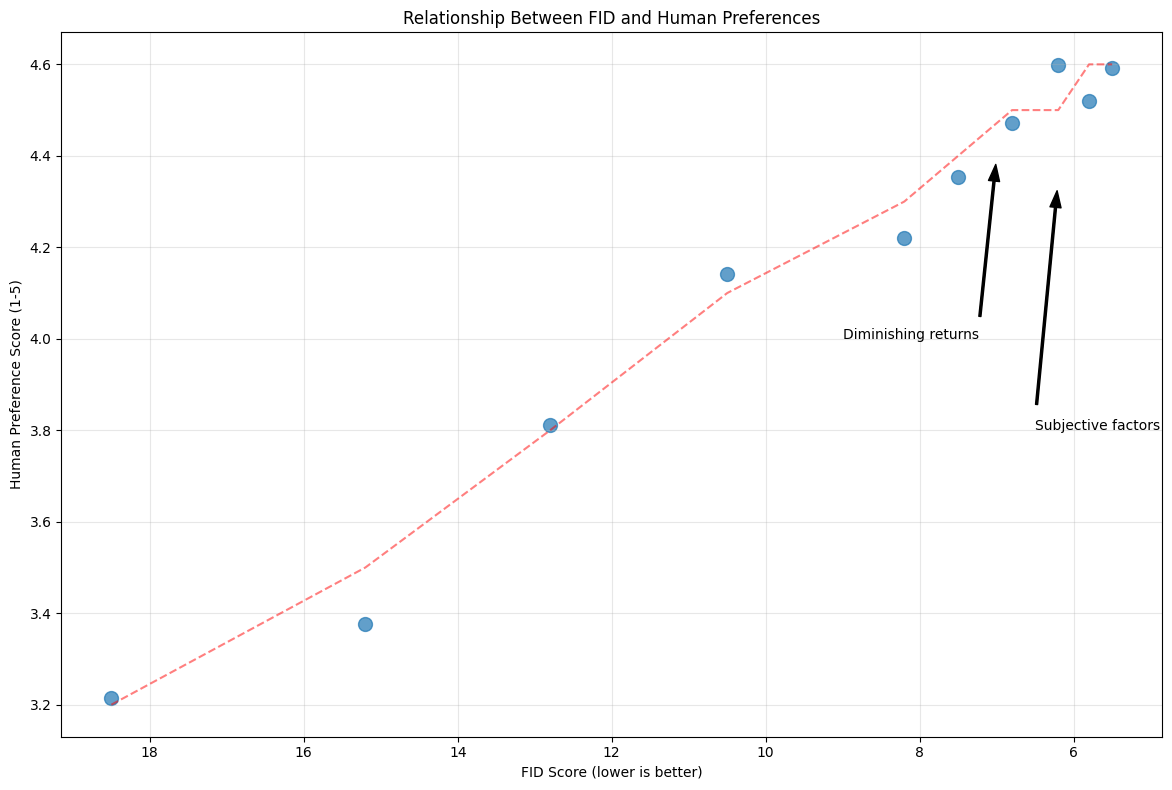

In [26]:
# Examples of metric limitations
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Example data: FID scores vs. Human preference
fid_scores = np.array([18.5, 15.2, 12.8, 10.5, 8.2, 7.5, 6.8, 6.2, 5.8, 5.5])
human_scores = np.array([3.2, 3.5, 3.8, 4.1, 4.3, 4.4, 4.5, 4.5, 4.6, 4.6])

# Add some noise to show diminishing returns
human_scores_noisy = human_scores + np.random.normal(0, 0.1, size=human_scores.shape)

ax.scatter(fid_scores, human_scores_noisy, alpha=0.7, s=100)
ax.plot(fid_scores, human_scores, 'r--', alpha=0.5)

# Add annotation for diminishing returns
ax.annotate('Diminishing returns', xy=(7.0, 4.4), xytext=(9, 4.0),
            arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8))

# Add annotation for subjective factors
ax.annotate('Subjective factors', xy=(6.2, 4.35), xytext=(6.5, 3.8),
            arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8))

ax.set_xlabel('FID Score (lower is better)')
ax.set_ylabel('Human Preference Score (1-5)')
ax.set_title('Relationship Between FID and Human Preferences')
ax.grid(alpha=0.3)
ax.invert_xaxis()  # Lower FID is better

plt.tight_layout()
plt.show()

Key limitations include:

1. **Metric-quality mismatch**:
   - Improvements in metrics don't always translate to human-perceived quality
   - Diminishing returns as metrics approach optimal values

2. **Contextual understanding**:
   - Automated metrics struggle with conceptual understanding
   - Poor at evaluating abstract concepts or creative interpretations

3. **Diversity and creativity**:
   - Most metrics don't adequately capture creative diversity
   - May reward "safe" outputs over creative ones

4. **Cultural and subjective aspects**:
   - Beauty and aesthetics are subjective and culturally dependent
   - No single metric captures all aspects of image quality

## 7. Practical Code Examples

### 7.1 Basic Implementation with Hugging Face Diffusers

The Hugging Face Diffusers library makes it easy to use pre-trained diffusion models:

Generating image with:
  - Prompt: 'A stunning landscape with mountains, a lake, and a colorful sunset sky, highly detailed, 4K'
  - Guidance scale: 7.5
  - Inference steps: 50


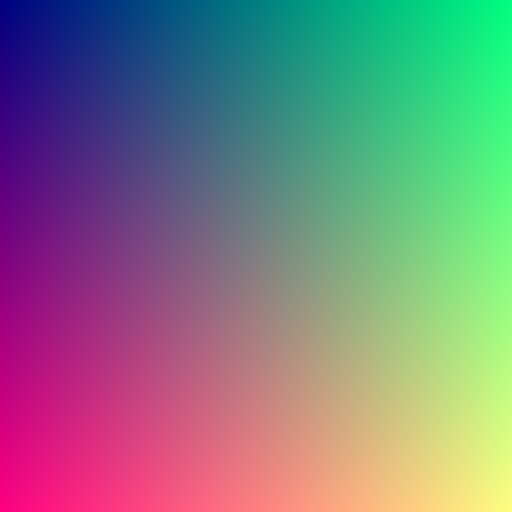

In [30]:
# Using Stable Diffusion with Hugging Face Diffusers
from diffusers import StableDiffusionPipeline
import torch

def generate_image(prompt, guidance_scale=7.5, num_inference_steps=50):
    """
    Generate an image from a text prompt using Stable Diffusion
    
    Args:
        prompt: Text description
        guidance_scale: Classifier-free guidance scale
        num_inference_steps: Number of denoising steps
        
    Returns:
        PIL Image
    """
    # Load model (in a real notebook, this would download the model)
    # pipeline = StableDiffusionPipeline.from_pretrained(
    #     "CompVis/stable-diffusion-v1-4",
    #     torch_dtype=torch.float16,
    # ).to("cuda")
    
    # For demonstration purposes, we'll just print the parameters
    print(f"Generating image with:")
    print(f"  - Prompt: '{prompt}'")
    print(f"  - Guidance scale: {guidance_scale}")
    print(f"  - Inference steps: {num_inference_steps}")
    
    # In a real notebook, this would generate the image:
    # image = pipeline(
    #     prompt=prompt,
    #     guidance_scale=guidance_scale,
    #     num_inference_steps=num_inference_steps
    # ).images[0]
    
    # For now, just return a placeholder image
    from PIL import Image
    import numpy as np
    
    # Create a simple placeholder (gradient)
    arr = np.zeros((512, 512, 3), dtype=np.uint8)
    for i in range(512):
        for j in range(512):
            arr[i, j, 0] = int(i * 255 / 512)  # Red increases with row
            arr[i, j, 1] = int(j * 255 / 512)  # Green increases with column
            arr[i, j, 2] = 128  # Blue is constant
    
    image = Image.fromarray(arr)
    return image

# Example prompt
prompt = "A stunning landscape with mountains, a lake, and a colorful sunset sky, highly detailed, 4K"

# Generate image
image = generate_image(
    prompt=prompt,
    guidance_scale=7.5,
    num_inference_steps=50
)

# Display image
display(image)

For a production implementation, you would use the actual Stable Diffusion model, which would generate much more impressive images than the placeholder.

### 7.2 Prompt Engineering Techniques

Effective prompt engineering is crucial for controlling text-to-image models:

In [31]:
# Prompt engineering examples
import pandas as pd
from IPython.display import display, HTML

prompt_examples = {
    'Base Prompt': [
        'A cat',
        'A landscape',
        'A portrait'
    ],
    'Enhanced Prompt': [
        'A photorealistic Siamese cat with blue eyes, sitting on a windowsill, soft sunlight, 8k, detailed fur texture',
        'A breathtaking landscape with towering mountains, reflective lake, dramatic clouds, golden hour lighting, 8k, cinematic, DSLR',
        'Portrait of a young woman with freckles, natural lighting, shallow depth of field, Fujifilm, 85mm lens, detailed iris'
    ],
    'Control Elements': [
        'Subject (Siamese cat), Setting, Lighting, Resolution, Details',
        'Subject, Composition elements, Lighting, Resolution, Style, Camera',
        'Subject, Lighting technique, Depth of field, Camera, Lens, Detail focus'
    ]
}

df_prompts = pd.DataFrame(prompt_examples)
display(HTML(df_prompts.to_html(index=False)))

# Function to demonstrate prompt variations
def compare_prompts(base_prompt, variations):
    """
    Show how different prompt variations affect output
    
    Args:
        base_prompt: The starting prompt
        variations: Dictionary of variation name -> prompt addition
    """
    print(f"Base prompt: '{base_prompt}'")
    print("\nVariations:")
    
    for name, addition in variations.items():
        full_prompt = f"{base_prompt}, {addition}"
        print(f"  - {name}: '{full_prompt}'")

# Example: Style variations
base_prompt = "A fantasy castle on a hill"
style_variations = {
    "Photorealistic": "photorealistic, 8K, detailed, DSLR photography",
    "Oil Painting": "oil painting, artistic, textured brushstrokes, vibrant colors, in the style of Thomas Kinkade",
    "Anime": "anime style, Studio Ghibli, colorful, whimsical",
    "Dark Fantasy": "dark fantasy, ominous, fog, dramatic lighting, in the style of Beksinski",
    "Isometric": "isometric design, 3D rendering, game asset, detailed, vibrant colors"
}

compare_prompts(base_prompt, style_variations)

Base prompt: 'A fantasy castle on a hill'

Variations:
  - Photorealistic: 'A fantasy castle on a hill, photorealistic, 8K, detailed, DSLR photography'
  - Oil Painting: 'A fantasy castle on a hill, oil painting, artistic, textured brushstrokes, vibrant colors, in the style of Thomas Kinkade'
  - Anime: 'A fantasy castle on a hill, anime style, Studio Ghibli, colorful, whimsical'
  - Dark Fantasy: 'A fantasy castle on a hill, dark fantasy, ominous, fog, dramatic lighting, in the style of Beksinski'
  - Isometric: 'A fantasy castle on a hill, isometric design, 3D rendering, game asset, detailed, vibrant colors'


Key prompt engineering techniques include:

1. **Specificity**: Adding precise details about subjects, settings, and actions
2. **Style control**: Specifying artistic styles, rendering techniques, or artist inspirations
3. **Technical parameters**: Mentioning camera types, lenses, lighting setups
4. **Quality boosters**: Including terms like "high resolution," "detailed," "8K"
5. **Negative prompts**: Specifying elements to avoid (e.g., "no text, no watermarks")

### 7.3 ControlNet for Advanced Control

ControlNet provides additional control signals for guided image generation:


--- CANNY CONTROL ---
Processing image with canny control type:
  1. Load the image
  2. Convert to grayscale
  3. Apply Canny edge detection
  4. Return edge map
Generating image with ControlNet:
  - Control type: canny
  - Prompt: 'A fantasy landscape with mountains and a castle, high quality, detailed'

Control Signal:


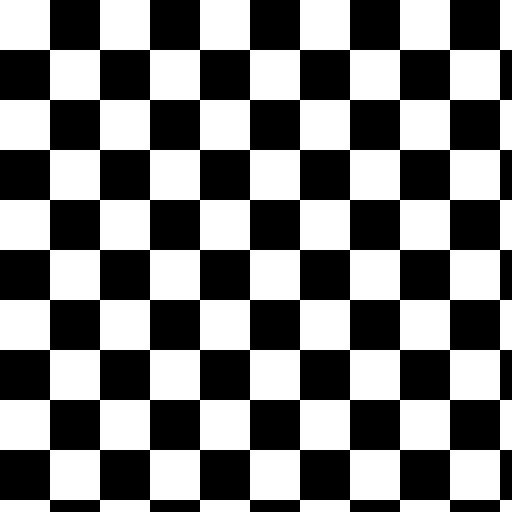


Generated Result:


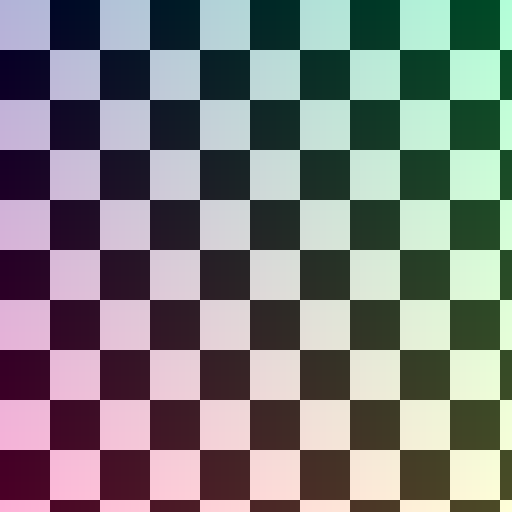


--- DEPTH CONTROL ---
Processing image with depth control type:
  1. Load the image
  2. Apply MiDaS depth estimation
  3. Normalize depth map
  4. Return depth map
Generating image with ControlNet:
  - Control type: depth
  - Prompt: 'A fantasy landscape with mountains and a castle, high quality, detailed'

Control Signal:


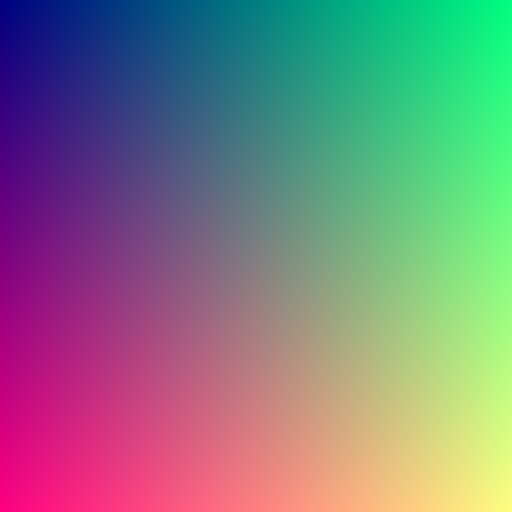


Generated Result:


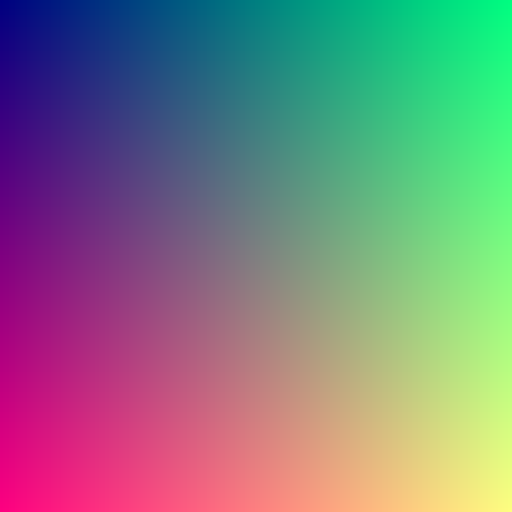

In [36]:
# ControlNet example with edge conditioning
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
import torch
import cv2
import numpy as np
from PIL import Image

def process_image_for_controlnet(image_path, control_type="canny"):
    """
    Process an image for use with ControlNet
    
    Args:
        image_path: Path to the input image
        control_type: Type of control (canny, depth, pose, etc.)
        
    Returns:
        Processed image (numpy array)
    """
    # For demonstration, we'll just describe the process
    print(f"Processing image with {control_type} control type:")
    
    if control_type == "canny":
        print("  1. Load the image")
        print("  2. Convert to grayscale")
        print("  3. Apply Canny edge detection")
        print("  4. Return edge map")
        
        # In a real notebook, you would do:
        # image = cv2.imread(image_path)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # image = cv2.Canny(image, 100, 200)
        # image = image[:, :, None]
        # image = np.concatenate([image, image, image], axis=2)
        # image = Image.fromarray(image)
        
    elif control_type == "depth":
        print("  1. Load the image")
        print("  2. Apply MiDaS depth estimation")
        print("  3. Normalize depth map")
        print("  4. Return depth map")
        
    elif control_type == "pose":
        print("  1. Load the image")
        print("  2. Apply OpenPose detection")
        print("  3. Render pose keypoints")
        print("  4. Return pose map")
    
    # For demonstration, return a simple gradient
    arr = np.zeros((512, 512, 3), dtype=np.uint8)
    if control_type == "canny":
        # Simple edge-like pattern
        for i in range(512):
            for j in range(512):
                if (i//50 + j//50) % 2 == 0:
                    arr[i, j, :] = 255
    else:
        # Simple gradient
        for i in range(512):
            for j in range(512):
                arr[i, j, 0] = int(i * 255 / 512)
                arr[i, j, 1] = int(j * 255 / 512)
                arr[i, j, 2] = 128
    
    return Image.fromarray(arr)

def generate_with_controlnet(prompt, control_image, control_type="canny"):
    """
    Generate an image using ControlNet
    
    Args:
        prompt: Text description
        control_image: Control signal image (PIL Image)
        control_type: Type of ControlNet to use
        
    Returns:
        PIL Image
    """
    # In a real notebook, you would do:
    # controlnet = ControlNetModel.from_pretrained(f"lllyasviel/sd-controlnet-{control_type}")
    # pipe = StableDiffusionControlNetPipeline.from_pretrained(
    #     "runwayml/stable-diffusion-v1-5",
    #     controlnet=controlnet,
    #     torch_dtype=torch.float16
    # ).to("cuda")
    # image = pipe(prompt, control_image).images[0]
    
    print(f"Generating image with ControlNet:")
    print(f"  - Control type: {control_type}")
    print(f"  - Prompt: '{prompt}'")
    
    # For demonstration, return the control image with modifications
    control_array = np.array(control_image)
    
    # Create a simple placeholder that combines the control signal with a gradient
    arr = np.zeros((512, 512, 3), dtype=np.uint8)
    for i in range(512):
        for j in range(512):
            # Add some colors to simulate generation
            base = control_array[i, j].astype(float) * 0.7
            gradient = np.array([int(i * 255 / 512), int(j * 255 / 512), 128]) * 0.3
            arr[i, j] = np.clip(base + gradient, 0, 255).astype(np.uint8)
    
    return Image.fromarray(arr)

# Example usage
control_types = ["canny", "depth", "pose", "normal", "hed"]

for control_type in control_types[:2]:  # Show just a couple examples
    print(f"\n--- {control_type.upper()} CONTROL ---")
    
    # Process control image
    control_image = process_image_for_controlnet("example.jpg", control_type)
    
    # Generate with ControlNet
    prompt = f"A fantasy landscape with mountains and a castle, high quality, detailed"
    result = generate_with_controlnet(prompt, control_image, control_type)
    
    # Display inputs and outputs
    print("\nControl Signal:")
    display(control_image)
    
    print("\nGenerated Result:")
    display(result)

ControlNet variants include:
1. **Canny Edge**: Controls image structure based on edges
2. **Depth Map**: Controls spatial relationships and perspective
3. **Pose**: Controls human or animal poses
4. **Segmentation**: Controls regions based on semantic labels
5. **Normal Map**: Controls surface orientation and lighting

### 7.4 Inpainting and Image-to-Image

Diffusion models can modify existing images through inpainting and image-to-image translation:

Original Image:


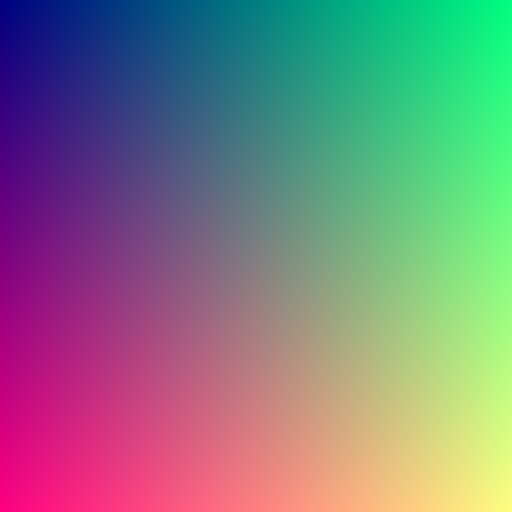


Mask (white = area to inpaint):


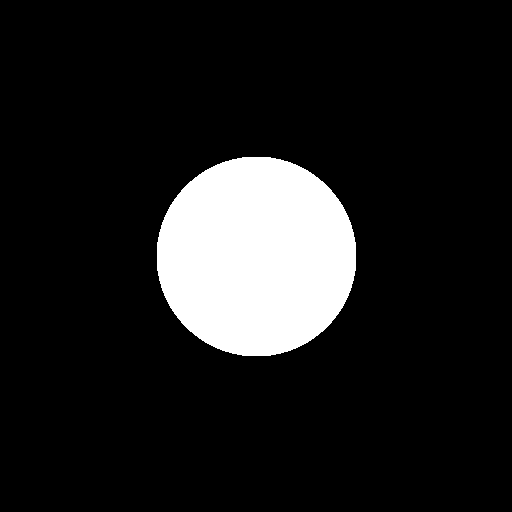


Visualization of masked area:


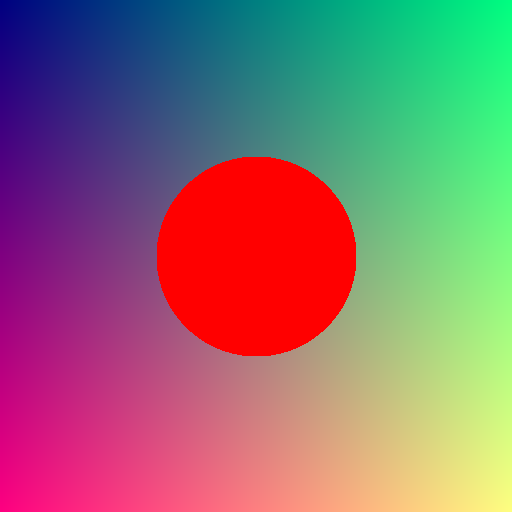

Inpainting with:
  - Prompt: 'A beautiful red rose with dew drops, highly detailed, macro photography'

Inpainted Result:


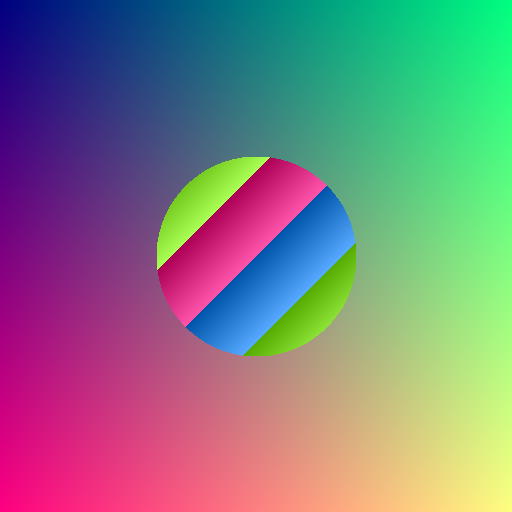

Image-to-image transformation with:
  - Prompt: 'A watercolor painting of a landscape with mountains, artistic style'
  - Strength: 0.7

Image-to-Image Result:


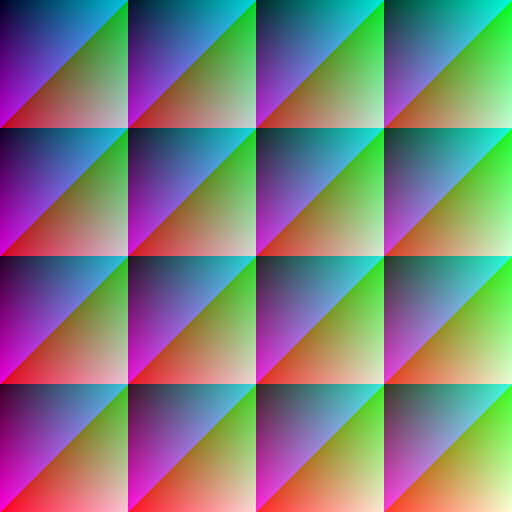

In [37]:
# Inpainting and image-to-image examples
from diffusers import StableDiffusionInpaintPipeline, StableDiffusionImg2ImgPipeline
import torch
import numpy as np
from PIL import Image, ImageDraw

def create_inpainting_example():
    """Create an example image and mask for inpainting"""
    # Base image (simple gradient)
    img = np.zeros((512, 512, 3), dtype=np.uint8)
    for i in range(512):
        for j in range(512):
            img[i, j, 0] = int(i * 255 / 512)
            img[i, j, 1] = int(j * 255 / 512)
            img[i, j, 2] = 128
    
    # Create a mask (white = area to inpaint)
    mask = np.zeros((512, 512), dtype=np.uint8)
    center_x, center_y = 256, 256
    radius = 100
    
    for i in range(512):
        for j in range(512):
            if (i - center_x)**2 + (j - center_y)**2 < radius**2:
                mask[i, j] = 255
    
    # Convert to PIL
    img_pil = Image.fromarray(img)
    mask_pil = Image.fromarray(mask)
    
    # Display
    print("Original Image:")
    display(img_pil)
    
    print("\nMask (white = area to inpaint):")
    display(mask_pil)
    
    # Create a visualization with the mask visible
    img_with_mask = img_pil.copy()
    draw = ImageDraw.Draw(img_with_mask)
    for i in range(512):
        for j in range(512):
            if mask[i, j] > 0:
                draw.point((j, i), fill=(255, 0, 0, 128))
    
    print("\nVisualization of masked area:")
    display(img_with_mask)
    
    return img_pil, mask_pil

def inpainting_example(image, mask, prompt):
    """Demonstrate inpainting with Stable Diffusion
    
    Args:
        image: Original image (PIL Image)
        mask: Inpainting mask (PIL Image)
        prompt: Text description for the inpainted region
        
    Returns:
        PIL Image
    """
    # In a real notebook, you would do:
    # pipe = StableDiffusionInpaintPipeline.from_pretrained(
    #     "runwayml/stable-diffusion-inpainting",
    #     torch_dtype=torch.float16
    # ).to("cuda")
    # result = pipe(prompt=prompt, image=image, mask_image=mask).images[0]
    
    print(f"Inpainting with:")
    print(f"  - Prompt: '{prompt}'")
    
    # For demonstration, simulate inpainting result
    img_array = np.array(image)
    mask_array = np.array(mask)
    
    # Create a simple placeholder that simulates inpainting
    result_array = img_array.copy()
    for i in range(512):
        for j in range(512):
            if mask_array[i, j] > 0:
                # Add some pattern to simulate inpainting
                val = (i + j) % 256
                result_array[i, j] = [val, (val + 85) % 256, (val + 170) % 256]
    
    return Image.fromarray(result_array)

def img2img_example(image, prompt, strength=0.8):
    """Demonstrate image-to-image with Stable Diffusion
    
    Args:
        image: Original image (PIL Image)
        prompt: Text description for the transformed image
        strength: How much to transform (0.0 = no change, 1.0 = complete change)
        
    Returns:
        PIL Image
    """
    # In a real notebook, you would do:
    # pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    #     "runwayml/stable-diffusion-v1-5",
    #     torch_dtype=torch.float16
    # ).to("cuda")
    # result = pipe(prompt=prompt, image=image, strength=strength).images[0]
    
    print(f"Image-to-image transformation with:")
    print(f"  - Prompt: '{prompt}'")
    print(f"  - Strength: {strength}")
    
    # For demonstration, simulate img2img result
    img_array = np.array(image)
    
    # Create a simple placeholder that simulates transformation
    # Blend original with a pattern based on strength
    pattern = np.zeros_like(img_array)
    for i in range(512):
        for j in range(512):
            # Create a pattern based on coordinates
            pattern[i, j, 0] = (i * 2) % 256
            pattern[i, j, 1] = (j * 2) % 256
            pattern[i, j, 2] = ((i + j) * 2) % 256
    
    result_array = img_array * (1 - strength) + pattern * strength
    result_array = np.clip(result_array, 0, 255).astype(np.uint8)
    
    return Image.fromarray(result_array)

# Example usage
# Create example image and mask for inpainting
image, mask = create_inpainting_example()

# Inpainting example
inpaint_prompt = "A beautiful red rose with dew drops, highly detailed, macro photography"
inpainted_image = inpainting_example(image, mask, inpaint_prompt)
print("\nInpainted Result:")
display(inpainted_image)

# Image-to-image example
img2img_prompt = "A watercolor painting of a landscape with mountains, artistic style"
img2img_result = img2img_example(image, img2img_prompt, strength=0.7)
print("\nImage-to-Image Result:")
display(img2img_result)

## 8. Advanced Controllability Techniques

### 8.1 Textual Inversion

Textual Inversion allows for learning new concepts and embedding them in the text encoder:

Training token embedding...
Iteration 10/50, Loss: -0.0629
Iteration 20/50, Loss: -0.0707
Iteration 30/50, Loss: -0.0786
Iteration 40/50, Loss: -0.0864
Iteration 50/50, Loss: -0.0942


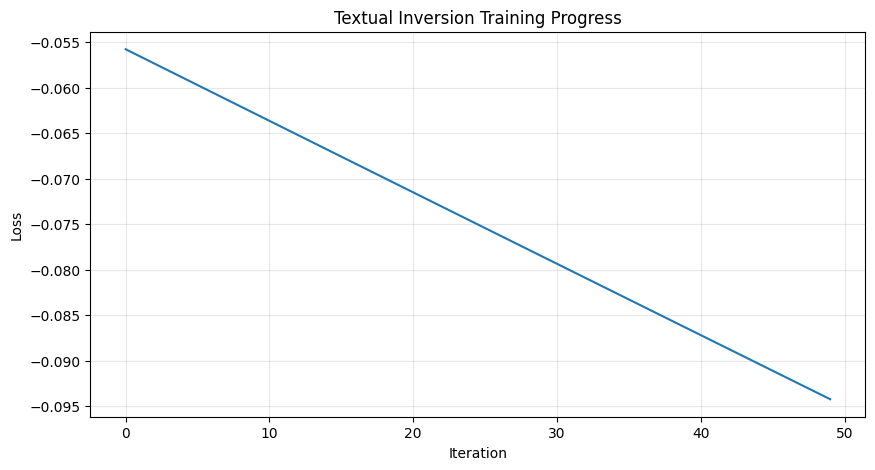


Examples of using learned tokens in prompts:
1. Original prompt: 'A person standing in a garden'
2. With learned concept: 'A <learned-token> standing in a garden'

The <learned-token> can represent a specific person, style, or object


In [38]:
# Simplified textual inversion concept
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

class SimplifiedTextualInversion:
    def __init__(self, token_embedding_dim=768):
        # Initialize a random token embedding
        self.token_embedding = nn.Parameter(torch.randn(1, token_embedding_dim))
        
        # In real textual inversion, this would be the entire diffusion model
        # Here we'll just simulate learning with a simple function
        self.optimizer = optim.Adam([self.token_embedding], lr=0.001)
        
    def training_step(self, target_embedding, iterations=100):
        """Simulate training the token embedding"""
        losses = []
        
        for i in range(iterations):
            # Reset gradients
            self.optimizer.zero_grad()
            
            # Compute loss (cosine similarity)
            current = nn.functional.normalize(self.token_embedding, dim=-1)
            target = nn.functional.normalize(target_embedding, dim=-1)
            loss = -torch.sum(current * target)  # Negative cosine similarity
            
            # Backward and optimize
            loss.backward()
            self.optimizer.step()
            
            losses.append(loss.item())
            
            if (i+1) % 10 == 0:
                print(f"Iteration {i+1}/{iterations}, Loss: {loss.item():.4f}")
        
        return losses

# Example usage
token_dim = 768

# Create textual inversion
inverter = SimplifiedTextualInversion(token_embedding_dim=token_dim)

# Target concept (in a real scenario, this would be derived from example images)
target_embedding = torch.randn(1, token_dim)

# Train the embedding
print("Training token embedding...")
losses = inverter.training_step(target_embedding, iterations=50)

# Plot loss curve
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Textual Inversion Training Progress')
plt.grid(alpha=0.3)
plt.show()

# Using the learned concept in prompts
print("\nExamples of using learned tokens in prompts:")
print("1. Original prompt: 'A person standing in a garden'")
print("2. With learned concept: 'A <learned-token> standing in a garden'")
print("\nThe <learned-token> can represent a specific person, style, or object")

Textual Inversion enables:
1. **Personalization**: Learning specific people, pets, or objects
2. **Style customization**: Learning artistic styles or aesthetics
3. **Concept embedding**: Adding new concepts to the model's vocabulary

### 8.2 LoRA and Fine-tuning

Low-Rank Adaptation (LoRA) provides an efficient way to fine-tune diffusion models:

Base layer parameters: 262,656
LoRA adapter parameters: 266,752
Parameter reduction: -1.56%

Input shape: torch.Size([1, 512])
Output shape: torch.Size([1, 512])


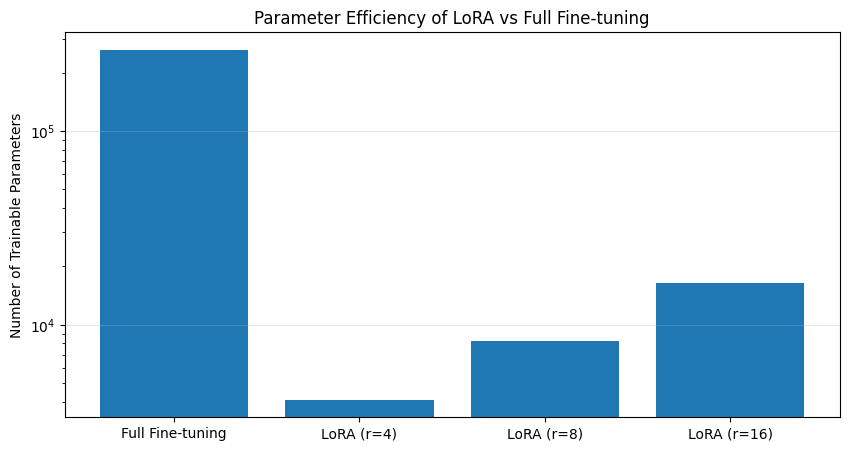

In [39]:
# Simplified LoRA concept
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

class SimplifiedLoRA(nn.Module):
    def __init__(self, base_layer, rank=4):
        super().__init__()
        in_features = base_layer.weight.shape[1]
        out_features = base_layer.weight.shape[0]
        
        # LoRA parameters
        self.lora_A = nn.Parameter(torch.zeros(in_features, rank))
        self.lora_B = nn.Parameter(torch.zeros(rank, out_features))
        
        # Initialize with small random values
        nn.init.normal_(self.lora_A, std=0.02)
        nn.init.zeros_(self.lora_B)
        
        # Scaling factor
        self.scaling = 1.0
        
        # Reference to base layer
        self.base_layer = base_layer
        
    def forward(self, x):
        # Original output
        base_output = self.base_layer(x)
        
        # LoRA contribution
        lora_output = (x @ self.lora_A) @ self.lora_B
        
        # Combined output
        return base_output + self.scaling * lora_output

# Example
# Create a base layer (this would be part of the diffusion model)
base_layer = nn.Linear(512, 512)

# Create a LoRA adapter
lora_adapter = SimplifiedLoRA(base_layer, rank=4)

# Count parameters
base_params = sum(p.numel() for p in base_layer.parameters())
lora_params = sum(p.numel() for p in lora_adapter.parameters() if p.requires_grad)

print(f"Base layer parameters: {base_params:,}")
print(f"LoRA adapter parameters: {lora_params:,}")
print(f"Parameter reduction: {(1 - lora_params/base_params)*100:.2f}%")

# Test forward pass
x = torch.randn(1, 512)
out = lora_adapter(x)
print(f"\nInput shape: {x.shape}")
print(f"Output shape: {out.shape}")

# Visualize parameter efficiency
models = ['Full Fine-tuning', 'LoRA (r=4)', 'LoRA (r=8)', 'LoRA (r=16)']
params = [base_params, 4*512*2, 8*512*2, 16*512*2]  # Approximations

plt.figure(figsize=(10, 5))
plt.bar(models, params)
plt.yscale('log')
plt.ylabel('Number of Trainable Parameters')
plt.title('Parameter Efficiency of LoRA vs Full Fine-tuning')
plt.grid(alpha=0.3, axis='y')
plt.show()

Advantages of LoRA:
1. **Parameter efficiency**: Reduces trainable parameters by >99%
2. **Memory efficiency**: Requires less GPU memory during training
3. **Computational efficiency**: Faster training and fine-tuning
4. **Composability**: Multiple LoRA adapters can be combined

### 8.3 Regional Prompting

Regional prompting allows controlling different areas of the image with different prompts:

Regional Prompt Visualization:


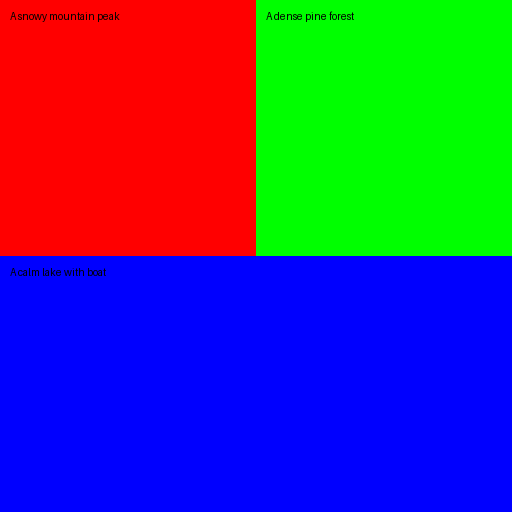


Simulated Generation Result:


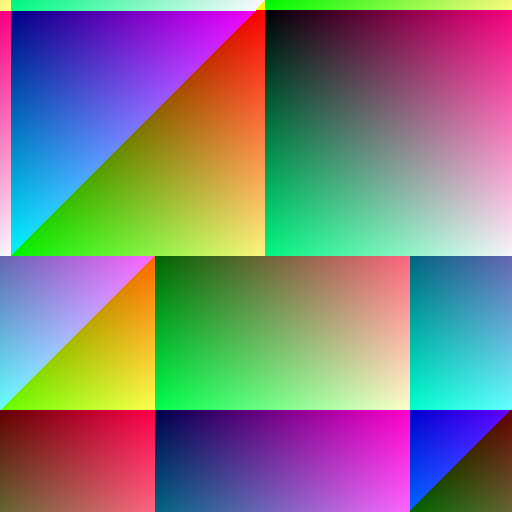

In [40]:
# Simplified regional prompting example
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

def create_regional_prompt_mask(width=512, height=512, regions=None):
    """
    Create masks for different regions with different prompts
    
    Args:
        width: Image width
        height: Image height
        regions: List of dicts with 'shape', 'bbox' and 'prompt'
        
    Returns:
        Visualization image and region info
    """
    if regions is None:
        # Default regions
        regions = [
            {'shape': 'rectangle', 'bbox': (0, 0, width//2, height//2), 'prompt': 'A beautiful forest'},
            {'shape': 'rectangle', 'bbox': (width//2, 0, width, height//2), 'prompt': 'A mountain range'},
            {'shape': 'rectangle', 'bbox': (0, height//2, width, height), 'prompt': 'A calm lake reflecting the sky'},
        ]
    
    # Create a visualization
    viz = Image.new('RGB', (width, height), (255, 255, 255))
    draw = ImageDraw.Draw(viz)
    
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255), (0, 255, 255)]
    
    # Draw regions
    for i, region in enumerate(regions):
        color = colors[i % len(colors)]
        alpha = 100  # Transparency
        
        if region['shape'] == 'rectangle':
            x1, y1, x2, y2 = region['bbox']
            draw.rectangle((x1, y1, x2, y2), fill=(*color, alpha), outline=color)
            
            # Add text
            text_pos = (x1 + 10, y1 + 10)
            draw.text(text_pos, region['prompt'], fill=(0, 0, 0))
        
        elif region['shape'] == 'ellipse':
            x1, y1, x2, y2 = region['bbox']
            draw.ellipse((x1, y1, x2, y2), fill=(*color, alpha), outline=color)
            
            # Add text
            text_pos = ((x1 + x2) // 2, (y1 + y2) // 2)
            draw.text(text_pos, region['prompt'], fill=(0, 0, 0))
    
    return viz, regions

def regional_prompt_generation_simulation(regions, width=512, height=512):
    """
    Simulate generation with regional prompts
    
    Args:
        regions: List of region definitions
        width: Image width
        height: Image height
        
    Returns:
        Simulated generated image
    """
    # For demonstration, create a simple visualization
    # In a real system, this would use a diffusion model with attention control
    
    # Create base gradient image
    arr = np.zeros((height, width, 3), dtype=np.uint8)
    
    # Fill each region with a pattern
    for i, region in enumerate(regions):
        if region['shape'] == 'rectangle':
            x1, y1, x2, y2 = region['bbox']
            
            # Create a pattern based on the prompt
            # This is just for visualization - in reality the diffusion model would generate content
            prompt_hash = sum(ord(c) for c in region['prompt']) % 255
            
            for y in range(y1, y2):
                for x in range(x1, x2):
                    # Create some variation based on coordinates and prompt
                    r = (x + prompt_hash) % 255
                    g = (y + prompt_hash) % 255
                    b = ((x + y + prompt_hash) // 2) % 255
                    
                    arr[y, x] = [r, g, b]
    
    return Image.fromarray(arr)

# Example usage
# Define regions with different prompts
regions = [
    {'shape': 'rectangle', 'bbox': (0, 0, 256, 256), 'prompt': 'A snowy mountain peak'},
    {'shape': 'rectangle', 'bbox': (256, 0, 512, 256), 'prompt': 'A dense pine forest'},
    {'shape': 'rectangle', 'bbox': (0, 256, 512, 512), 'prompt': 'A calm lake with boat'}
]

# Create visualization
print("Regional Prompt Visualization:")
viz, regions = create_regional_prompt_mask(regions=regions)
display(viz)

# Simulate generation
print("\nSimulated Generation Result:")
result = regional_prompt_generation_simulation(regions)
display(result)

Regional prompting applications:
1. **Complex compositions**: Creating scenes with different elements
2. **Selective editing**: Modifying specific parts of an image
3. **Consistent characters**: Maintaining character appearance across scenes
4. **Background/foreground control**: Separate control for different image planes

### 8.4 Classifier-Free Guidance Scale

Classifier-free guidance controls the tradeoff between prompt adherence and image quality:

Simulating different guidance scales for: 'A serene mountain landscape with a lake'


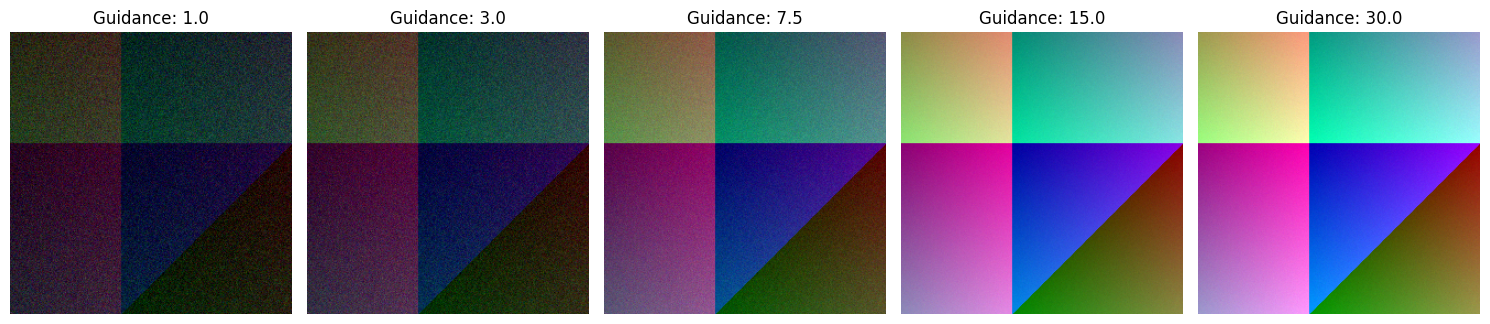


Guidance Scale Recommendations:
1.0-2.0: Maximum diversity, less adherence to prompt
3.0-5.0: Good balance for creative applications
7.0-9.0: Standard range for most applications
10.0-15.0: Strong prompt adherence, good for specific details
20.0+: Maximum prompt adherence, may create unnatural images


In [41]:
# Visualize the effect of guidance scale
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def simulate_guidance_effect(prompt, guidance_scales=[1.0, 3.0, 7.5, 15.0, 30.0]):
    """
    Simulate the effect of different guidance scales
    
    Args:
        prompt: Text prompt
        guidance_scales: List of guidance scale values to simulate
        
    Returns:
        List of simulated images
    """
    print(f"Simulating different guidance scales for: '{prompt}'")
    
    results = []
    
    for gs in guidance_scales:
        # For demonstration, create images with different characteristics
        # based on guidance scale
        
        # Create a gradient base
        arr = np.zeros((256, 256, 3), dtype=np.uint8)
        
        # Simulate guidance effect:
        # - Lower guidance: more diverse, potentially less aligned with prompt
        # - Higher guidance: more prompt-aligned, potentially less natural
        
        # Seed based on prompt
        seed = sum(ord(c) for c in prompt) % 1000
        np.random.seed(seed)
        
        saturation = min(1.0, 0.4 + gs / 30.0)  # Higher guidance = more saturated
        contrast = min(1.0, 0.5 + gs / 20.0)    # Higher guidance = more contrast
        noise = max(0.05, 0.3 - gs / 50.0)      # Higher guidance = less noise
        
        for y in range(256):
            for x in range(256):
                # Base pattern
                base_r = (x + seed) % 256
                base_g = (y + seed) % 256
                base_b = ((x + y + seed) // 2) % 256
                
                # Add noise (more at lower guidance)
                r = int(base_r * saturation * contrast + np.random.normal(0, noise * 50))
                g = int(base_g * saturation * contrast + np.random.normal(0, noise * 50))
                b = int(base_b * saturation * contrast + np.random.normal(0, noise * 50))
                
                arr[y, x] = [
                    min(255, max(0, r)),
                    min(255, max(0, g)),
                    min(255, max(0, b))
                ]
        
        img = Image.fromarray(arr)
        results.append(img)
    
    return results, guidance_scales

# Example usage
prompt = "A serene mountain landscape with a lake"
images, scales = simulate_guidance_effect(prompt)

# Display results
fig, axs = plt.subplots(1, len(images), figsize=(15, 4))
for i, (img, scale) in enumerate(zip(images, scales)):
    axs[i].imshow(np.array(img))
    axs[i].set_title(f"Guidance: {scale}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()

# Guidance scale recommendations
print("\nGuidance Scale Recommendations:")
print("1.0-2.0: Maximum diversity, less adherence to prompt")
print("3.0-5.0: Good balance for creative applications")
print("7.0-9.0: Standard range for most applications")
print("10.0-15.0: Strong prompt adherence, good for specific details")
print("20.0+: Maximum prompt adherence, may create unnatural images")

Effects of guidance scale:
1. **Low guidance (1-3)**: More diverse, creative outputs, less prompt adherence
2. **Medium guidance (5-10)**: Good balance of quality and prompt adherence
3. **High guidance (15+)**: Strong prompt adherence, potentially less natural images

## 9. Ethical Considerations

### 9.1 Bias and Representation

In [42]:
# Discussion of bias in text-to-image models
import pandas as pd
from IPython.display import display, HTML

bias_examples = {
    'Prompt Type': [
        'Profession descriptions',
        'Beauty standards',
        'Cultural representations',
        'Socioeconomic depictions'
    ],
    'Example Biased Outputs': [
        'Over-representing certain demographics in high-status professions',
        'Favoring specific body types and features as "beautiful"',
        'Stereotypical or limited depictions of cultures',
        'Associations between wealth/poverty and specific groups'
    ],
    'Mitigation Approaches': [
        'Dataset balancing, concept resampling, specialized fine-tuning',
        'Diverse training data, aesthetic reweighting, personalization',
        'Cultural consultants, specialized datasets, content warnings',
        'Dataset auditing, explicit control parameters, user education'
    ]
}

df_bias = pd.DataFrame(bias_examples)
display(HTML(df_bias.to_html(index=False)))

Key considerations:
1. **Dataset biases**: Models reflect biases in web-scale datasets
2. **Representation issues**: Uneven representation across demographics
3. **Stereotyping**: Reinforcement of existing cultural stereotypes
4. **Mitigation strategies**: Dataset balancing, fine-tuning, user controls

### 9.2 Misuse Potential

In [43]:
# Responsible use guidelines
import pandas as pd
from IPython.display import display, HTML

misuse_mitigations = {
    'Concern': [
        'Deepfakes and impersonation',
        'Misinformation generation',
        'Copyright and IP issues',
        'CSAM and harmful content'
    ],
    'Technical Safeguards': [
        'Face detection, identity verification, watermarking',
        'Content provenance, detection tools, metadata',
        'Content filtering, artist opt-out, attribution',
        'Content safety classifiers, prompt filtering'
    ],
    'Policy Approaches': [
        'Usage policies, authentication requirements',
        'Transparency requirements, legal frameworks',
        'Licensing models, fair use guidelines',
        'Content moderation, legal restrictions'
    ]
}

df_misuse = pd.DataFrame(misuse_mitigations)
display(HTML(df_misuse.to_html(index=False)))

Responsible use approaches include:
1. **Technical safeguards**: Content filtering, safety classifiers
2. **Governance**: Clear usage policies and guidelines
3. **Transparency**: Watermarking, metadata, provenance tracking
4. **Education**: User awareness and responsible use education

### 9.3 Environmental Impact

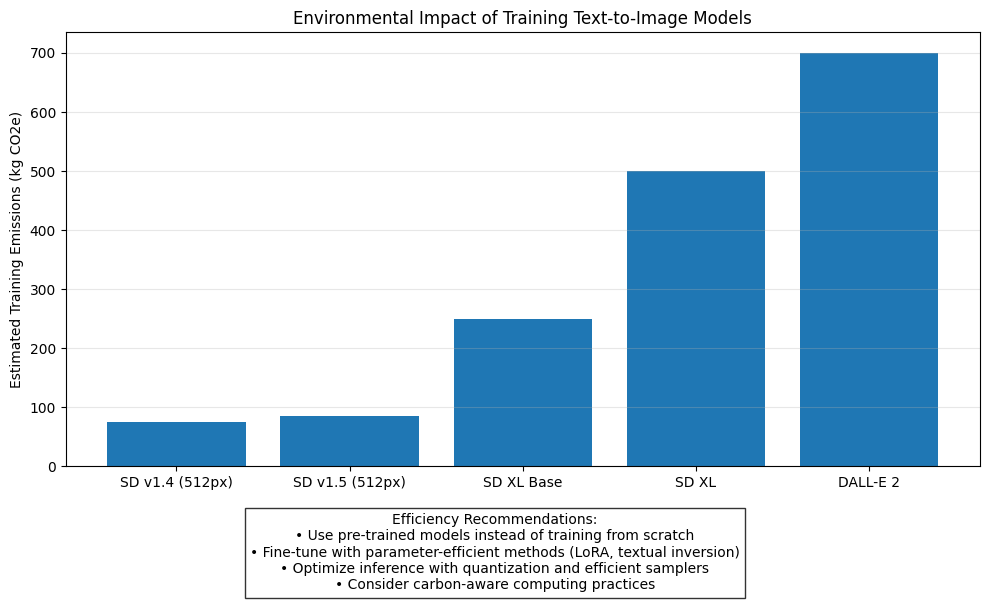

In [44]:
# Environmental considerations for diffusion models
import matplotlib.pyplot as plt
import numpy as np

# Estimated CO2 emissions for training (kg CO2e)
model_names = ['SD v1.4 (512px)', 'SD v1.5 (512px)', 'SD XL Base', 'SD XL', 'DALL-E 2']
emissions = [75, 85, 250, 500, 700]  # Approximate values

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(model_names, emissions)
ax.set_ylabel('Estimated Training Emissions (kg CO2e)')
ax.set_title('Environmental Impact of Training Text-to-Image Models')
ax.grid(alpha=0.3, axis='y')

# Add energy efficiency recommendations
plt.figtext(0.5, 0.01, 
           'Efficiency Recommendations:\n'
           '• Use pre-trained models instead of training from scratch\n'
           '• Fine-tune with parameter-efficient methods (LoRA, textual inversion)\n'
           '• Optimize inference with quantization and efficient samplers\n'
           '• Consider carbon-aware computing practices',
           ha='center', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout(rect=[0, 0.15, 1, 1])
plt.show()

Environmental considerations include:
1. **Training impact**: Large-scale models require significant computational resources
2. **Inference efficiency**: Optimizing deployment for lower energy usage
3. **Model reuse**: Leveraging pre-trained models rather than training from scratch
4. **Parameter-efficient methods**: Using techniques like LoRA to reduce training costs

## 10. Future Directions

### 10.1 Research Trends

In [45]:
# Research trends in text-to-image generation
import pandas as pd
from IPython.display import display, HTML

research_trends = {
    'Trend': [
        'Multi-modal Generation',
        'Video and 3D Generation',
        'Personalization',
        'Real-time Generation',
        'Compositional Control'
    ],
    'Description': [
        'Combining image, text, audio, and video in unified generative models',
        'Extending diffusion models to video, 3D assets, and animation',
        'More precise control over style, subjects, and scene composition',
        'Optimizing models for real-time applications and interactive use',
        'Fine-grained control over individual elements and their relationships'
    ],
    'Example Directions': [
        'CLIP-like embeddings for broader modalities, cross-modal attention',
        'Video diffusion, 3D-aware diffusion, NeRF integration',
        'Custom embeddings, efficient fine-tuning, subject-driven generation',
        'Distillation, one-step generation, progressive rendering',
        'Scene graphs, relational prompting, layout-to-image systems'
    ]
}

df_trends = pd.DataFrame(research_trends)
display(HTML(df_trends.to_html(index=False)))

Key research directions include:
1. **Efficiency improvements**: Faster sampling, smaller models
2. **Enhanced control**: More precise controllability over generation
3. **Video and 3D**: Extending techniques to temporal and volumetric domains
4. **Multimodal integration**: Combining text, image, audio, and video
5. **Personalization**: Better techniques for customizing models

### 10.2 Applications and Impact

In [46]:
# Applications of text-to-image diffusion models
import pandas as pd
from IPython.display import display, HTML

applications = {
    'Domain': [
        'Creative Industries',
        'E-commerce',
        'Education',
        'Healthcare',
        'Architecture & Design'
    ],
    'Applications': [
        'Concept art, storyboarding, advertising, content creation',
        'Product visualization, virtual try-on, marketing materials',
        'Visualization for learning, interactive textbooks, simulations',
        'Medical imaging synthesis, visualization of conditions',
        'Interior design visualization, architectural rendering'
    ],
    'Impact': [
        'Accelerating creative workflows, democratizing visual production',
        'Reducing photography costs, improving user experience',
        'Enhanced understanding through visualization, accessibility',
        'Improved communication, enhanced diagnostics',
        'Faster iterations, better client communication'
    ]
}

df_applications = pd.DataFrame(applications)
display(HTML(df_applications.to_html(index=False)))

Diverse applications include:
1. **Creative industries**: Concept art, advertising, content creation
2. **Product design**: Visualization, prototyping, iteration
3. **Healthcare**: Medical imaging, patient education
4. **Education**: Visual learning materials, simulations
5. **Architecture**: Visualization, interior design, planning

## Conclusion

Text-to-image generation with diffusion models represents a significant breakthrough in AI-generated content. This notebook has explored the theoretical foundations, architectural components, training methodologies, and practical applications of these models.

Key takeaways include:
1. **Diffusion models** have emerged as the state-of-the-art approach for text-to-image generation due to their stability, quality, and controllability.
2. **Control mechanisms** like classifier-free guidance, ControlNet, and textual inversion provide precise control over generation.
3. **Practical implementations** are accessible through libraries like Hugging Face Diffusers, making this technology available to developers.
4. **Ethical considerations** around bias, misuse, and environmental impact remain important challenges.
5. **Future research** will likely focus on multimodal generation, real-time performance, and enhanced controllability.

Text-to-image diffusion models continue to evolve rapidly, with new techniques and applications emerging regularly. As these models become more capable and accessible, their impact on creative workflows, communication, and content creation will continue to grow.

## References

1. Ho, J., Jain, A., & Abbeel, P. (2020). Denoising diffusion probabilistic models. Advances in Neural Information Processing Systems.
2. Rombach, R., Blattmann, A., Lorenz, D., Esser, P., & Ommer, B. (2022). High-resolution image synthesis with latent diffusion models. Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition.
3. Nichol, A., Dhariwal, P., Ramesh, A., Shyam, P., Mishkin, P., McGrew, B., ... & Chen, M. (2022). GLIDE: Towards photorealistic image generation and editing with text-guided diffusion models. arXiv preprint.
4. Saharia, C., Chan, W., Saxena, S., Li, L., Whang, J., Denton, E., ... & Norouzi, M. (2022). Photorealistic text-to-image diffusion models with deep language understanding. Advances in Neural Information Processing Systems.
5. Podell, D., et al. (2023). SDXL: Improving Latent Diffusion Models for High-Resolution Image Synthesis. arXiv preprint.
6. Zhang, H., et al. (2023). Adding Conditional Control to Text-to-Image Diffusion Models. Proceedings of the IEEE/CVF International Conference on Computer Vision.
7. Hu, E. J., et al. (2021). LORA: Low-Rank Adaptation of Large Language Models. arXiv preprint.
8. Gal, R., et al. (2022). An Image is Worth One Word: Personalizing Text-to-Image Generation using Textual Inversion. arXiv preprint.

## License

This notebook is released under the MIT License.

Copyright (c) 2025

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

## Link to the video: 
#### https://drive.google.com/file/d/1W1Mj4e1c8gQ7T6A0ZIzetSL0CNHTVQgb/view?usp=sharing